# 📜 Summary 📜
This is an EDA of the playground series data from season 3 episode 9.\
The data is synthetic and asks to predict **cement strength** which looks to be a continuous feature\

<blockquote style="margin-right:auto; margin-left:auto; background-color: #9debb2; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Note: this is a Regression problem  </span></b>
    
The dataset for this competition (both train and test) was generated from a deep learning model trained on the original Cement Stregth dataset
Feature distributions are close to, but not exactly the same, as the original i.e the data is synthetic
The metric required to be used by the competition is Root Mean Square Error

# 🏠 Load libraries & data 🏠

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import log_loss, mean_squared_error, roc_auc_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RepeatedStratifiedKFold,StratifiedKFold, RepeatedKFold
from scipy.stats import boxcox, median_abs_deviation 
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, RFECV, SelectKBest
from sklearn.decomposition import PCA

import shap 
import lightgbm as lgb
import catboost as cat
import xgboost as xgb
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.svm import SVR
from imblearn.over_sampling import SMOTE

### Load data

In [2]:
df_train = pd.read_csv("/kaggle/input/playground-series-s3e9/train.csv", index_col = 0)
df_test = pd.read_csv("/kaggle/input/playground-series-s3e9/test.csv", index_col = 0)
sub = pd.read_csv("/kaggle/input/playground-series-s3e9/sample_submission.csv",index_col = 0)
df_train

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
id,,,,,,,,,
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19
...,...,...,...,...,...,...,...,...,...
5402,446.0,24.0,79.0,162.0,11.6,967.0,712.0,3,15.42
5403,350.0,0.0,0.0,203.0,0.0,974.0,775.0,180,49.20
5404,295.8,0.0,0.0,185.7,0.0,1076.2,759.3,28,39.30


### Set Project Parameters
Below we set parameters that we will use to re-run this notebook with different aspects 

In [3]:
target = "Strength" #Target column that we will be predicting, this is here for quick reference 

# Different scaling options
SCALING = True
DISTRIBUTION = True
OUTLIERS= True
PCA_run= False

# Feature engineering and model training options
ADD_DATA = True
TEST_ON_GENERATED_ONLY = True
EPOCHS= 2000

NUM_FOLDS = 5
NUM_SPLITS = 3

SHAP_VALS = False
CALIBRATION = "linear"

# Notebook settings
sns.set_style("darkgrid")
pd.set_option('mode.chained_assignment',None)

### Additional data
The synthetic data in the competition (df_train) was created from an original dataset. We can add this original data to our training data to (hopefully) improve model prediction
* An additional column (is_generated) is added to show if this is the training or the additional data
* We add this here to be included in our EDA

In [4]:
if ADD_DATA:
    add_data = pd.read_csv('/kaggle/input/predict-concrete-strength/ConcreteStrengthData.csv')
    
    print("length of additional data", len(add_data))
    print("length of original data", len(df_train))
    df_train['is_generated'] = 1
    df_test['is_generated'] = 1
    add_data['is_generated'] = 0
    add_data.columns =df_train.columns

    df_train = pd.concat([df_train, add_data],axis=0, ignore_index=True)
df_train

length of additional data 1030
length of original data 5407


,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,is_generated
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,1
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,1
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,1
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,1
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,1
...,...,...,...,...,...,...,...,...,...,...
6432,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,0
6433,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18,0
6434,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70,0
6435,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77,0


## Helper Functions

In [5]:
def base_model(X_trn,y_trn,X_tst,y_tst, name,model, X_in, test_in, print_scores = True):
    
    if name in ["lightgbm"]:
        model.fit(X_trn,y_trn,
              eval_set=[(X_tst,y_tst)],
              callbacks= [lgb.log_evaluation(0), lgb.early_stopping(30,verbose=0)])
        
    elif name in ["xgboost"]:
        model.fit(X_trn,y_trn,
                 eval_set=[(X_tst,y_tst)],
                  verbose= 0
                 )
    elif name in ["catboost"]:
        model.fit(X_trn,y_trn,
                  eval_set=[(X_tst,y_tst)],
                  early_stopping_rounds=30,
                  verbose= 0
                 )          
    else:
        model.fit(X_trn,y_trn)

    val_preds = model.predict(X_tst)
    trn_preds = model.predict(X_in)
    test_preds = model.predict(test_in)
    
    score_trn =mean_squared_error(y, trn_preds)**0.5
    score_val = mean_squared_error(y_tst, val_preds )**0.5
    
    if print_scores:
        print("\nTrn Score:",score_trn)
        print("Val Score:",score_val)
        #print("Val logloss", log_loss(y,trn_preds_base))
    
    return test_preds, trn_preds, val_preds, score_trn, score_val

In [6]:
def Scaling(X_train, X_test, test_df, X= None) : 
    
    """Scaling and Sampling Helper function: 
        Scales and oversamples training and validation dataframes 
    
    :param 
        X_train: pandas dataframe of training data , less target values
        X_test: pandas dataframe of validation data , less target values
        test_df: pandas dataframe of test data , less target values
        y_train: pandas dataframe or series of target training values
        X: pandas dataframe of training and validation data, less target values
        
    :return: scaled input paramaters as pandas dataframes 

    """
    
    test_s = test_df.copy(deep = True)
    X_train_s = X_train.copy(deep = True)
    X_test_s = X_test.copy(deep = True)
    
    if X is not None:
        X_s = X.copy(deep = True)
    
    if OUTLIERS and len(outliers)>0:
        #Scale outliers: see boxplots
        scaler = RobustScaler()
        X_train_s[outliers] = scaler.fit_transform(X_train_s[outliers])
        X_test_s[outliers]  = scaler.transform(X_test_s[outliers])
        test_s[outliers] = scaler.transform(test_s[outliers])
        if X is not None:
            X_s[outliers] = scaler.transform(X_s[outliers])
    
    if DISTRIBUTION:
        #Scale Skewness: see distribution
        scaler = QuantileTransformer(output_distribution="normal")
        X_train_s[non_dist_cols] = scaler.fit_transform(X_train_s[non_dist_cols])
        X_test_s[non_dist_cols] = scaler.transform(X_test_s[non_dist_cols])
        test_s[non_dist_cols] = scaler.transform(test_s[non_dist_cols])
        if X is not None:
            X_s[non_dist_cols] = scaler.transform(X_s[non_dist_cols])
            
    if SCALING: 
        scaler = StandardScaler()
        X_train_s[scaled_cols] = scaler.fit_transform(X_train_s[scaled_cols])
        X_test_s[scaled_cols] = scaler.transform(X_test_s[scaled_cols])
        test_s[scaled_cols] = scaler.transform(test_s[scaled_cols])
        if X is not None:
            X_s[scaled_cols] = scaler.transform(X_s[scaled_cols])

              
    if X is not None:
        return pd.DataFrame(X_train_s, columns = X.columns )   , pd.DataFrame(X_test_s, columns = X.columns ) , pd.DataFrame(test_s, columns = test_df.columns ) , pd.DataFrame(X_s, columns = X.columns )  
    else:
        return pd.DataFrame(X_train_s, columns = X.columns ), pd.DataFrame(X_test_s, columns = X.columns )  , pd.DataFrame(test_s, columns = test_df.columns )

In [7]:
def SMAPE(y_true, y_pred):
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

# 📃 Basic Analysis 📃
In the basic analysis section we want to get a feel of the data, the number of samples, features and target. We will refer back to this section as we explore the data more indepth

In [8]:
print("Initial look at the data")
df_train.head()

Initial look at the data


,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,is_generated
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,1
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,1
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,1
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,1
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,1


In [9]:
print("First 5 rows of Target")
display(df_train[target].head())

First 5 rows of Target


0    10.38
1    23.52
2    36.96
3    39.05
4    74.19
Name: Strength, dtype: float64

In [10]:
print("Unique datatypes:\n",df_train.dtypes.unique())

Unique datatypes:
 [dtype('float64') dtype('int64')]


In [11]:
print("Column information:\n")
df_train.info()

Column information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6437 entries, 0 to 6436
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CementComponent            6437 non-null   float64
 1   BlastFurnaceSlag           6437 non-null   float64
 2   FlyAshComponent            6437 non-null   float64
 3   WaterComponent             6437 non-null   float64
 4   SuperplasticizerComponent  6437 non-null   float64
 5   CoarseAggregateComponent   6437 non-null   float64
 6   FineAggregateComponent     6437 non-null   float64
 7   AgeInDays                  6437 non-null   int64  
 8   Strength                   6437 non-null   float64
 9   is_generated               6437 non-null   int64  
dtypes: float64(8), int64(2)
memory usage: 503.0 KB


In [12]:
print("Statistical values of features\n")
df_train.describe()

Statistical values of features



,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,is_generated
count,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000
mean,296.287914,61.056408,35.443561,184.514758,4.443862,988.947395,771.597685,50.777225,35.510618,0.839988
std,105.571750,84.062442,56.800359,19.041684,5.789045,77.555433,78.957633,68.990009,16.450129,0.366646
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000,0.000000
25%,212.500000,0.000000,0.000000,173.000000,0.000000,938.000000,734.300000,7.000000,23.690000,1.000000
50%,295.800000,0.000000,0.000000,186.000000,0.000000,975.600000,781.000000,28.000000,33.960000,1.000000
75%,374.000000,129.900000,94.000000,192.000000,8.700000,1047.000000,821.000000,56.000000,45.850000,1.000000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000,1.000000


In [13]:
print("Null values: \nTrain:", df_train.isnull().sum().sum(), "\nTest:",df_test.isnull().sum().sum())

Null values: 
Train: 0 
Test: 0


In [14]:
print("Infinite values: \nTrain:",np.isinf(df_train).sum().sum())#.sort_values(ascending = False))
print("Test:",np.isinf(df_test).sum().sum())#.sort_values(ascending = False))

Infinite values: 
Train: 0
Test: 0


In [15]:
print("Number of Duplicates in train:",df_train.duplicated().sum())
print("Number of Duplicates in test:",df_test.duplicated().sum())

Number of Duplicates in train: 25
Number of Duplicates in test: 1351


In [16]:
print("Duplicated targets:\n", df_train[df_train.duplicated()][target].value_counts())

Duplicated targets:
 35.30    3
71.30    3
77.30    3
79.30    3
33.40    2
49.20    2
55.90    2
60.29    2
64.30    2
65.20    2
19.69    1
Name: Strength, dtype: int64


<blockquote style="margin-right:auto; margin-left:auto; background-color: #9debb2; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Notes on basic EDA:  </span></b>
    
* **No null values.** We therefore dont need to use imputation 
* **Categorical data** ==> No Categorical data 
* Data types are all float values excluding the target (integer)
* Data is reasonably small with only 6437 datapoints 
* Using **df.describe()** is hard to understand the data with so many columns and without visualisation. We will refer back to this data in our visualisation section
* **Duplicates**: We should drop duplicates as this will cause our model to overfit and give us overinflated scores as it will 'learn' the one duplicate and perfectly predict the other 

## 📈 Target Analysis 📈
This is a Mutli-class classification problem, where we are expected to predict the quality of wine on a 8 rating scale.\
From the below we can see that we only have wine quality starting from 3 --> 8


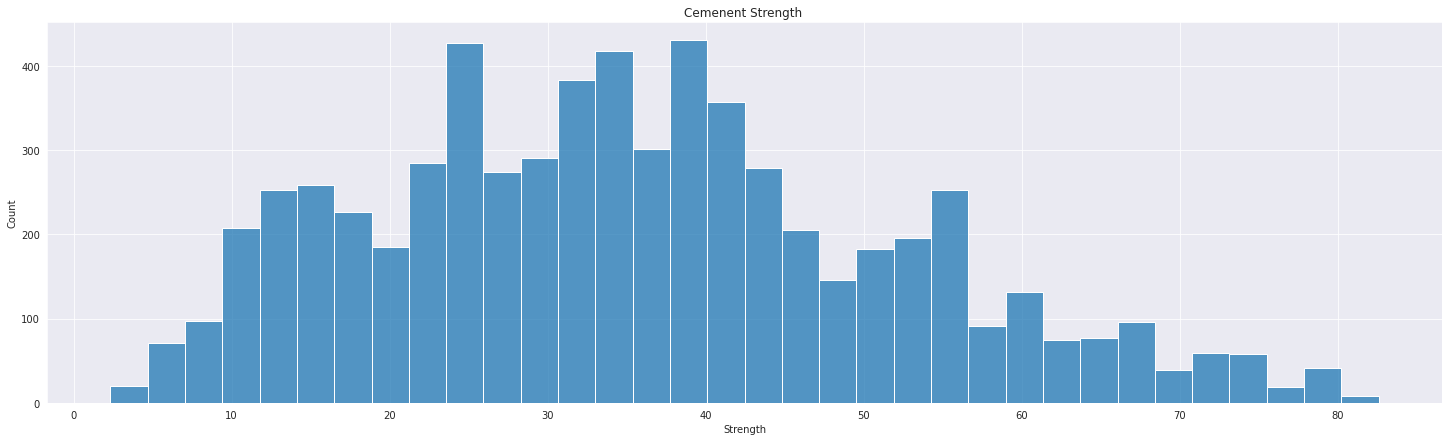

In [17]:
fig, ax = plt.subplots(figsize = (25,7))
sns.histplot(x= df_train[target])
plt.title("Cemenent Strength ")
plt.show()

<blockquote style="margin-right:auto; margin-left:auto; background-color: #9debb2; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Notes  </span></b>

* Generally normally distributed, we can improve this with by transforming our target however I would be wary of doing this:
    * i.e. log transform of target 
    

# 🚀 Distribution & Skewness 🚀
Why look at distribution:
* Many ML algorithms are more accurate when training on data that is normally distributed. Specifically linear models like LDA, Gaussian Naive Bayes, Logistic Regression, Linear Regression as they are explicitly calculated from the assumption that the residuals are Normally (Guassian) distributed 
* Note that Gradient boosting models can compute faster with normally distrubuted values but dont neccessarily improve with normally distributed data 

##### **Normal Distribution (centre around the mean)**

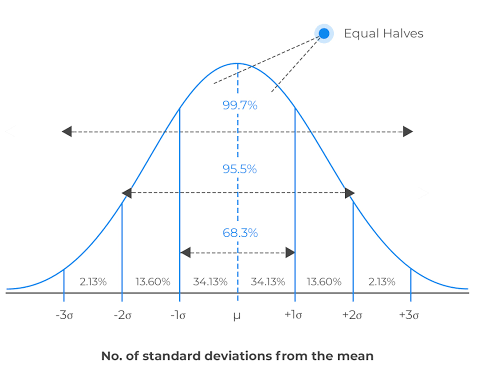

In [18]:
numerical = [col for col in df_train.select_dtypes(["int64", "float64","int32", "float32"]).columns if col not in [target, "is_generated"]]
categorical = [col for col in df_train.select_dtypes("object").columns if col!=target]
print("Numerical Columns:\n",numerical)
print("\n")
print("Categorical Columns:\n",categorical)

Numerical Columns:
 ['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent', 'WaterComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays']


Categorical Columns:
 []


#### Categorical Data (Count)
Categorical data does not need to be normally distrubuted as it is discrete, we will therefore visualise the data with countplots/barplots to get a better indication of how it looks against the target

Note: we dont have any categorical columns for this data, so the below is ignored 

In [19]:
if len(categorical)>0:
    fig,ax = plt.subplots(4,2,figsize = (25,25))
    total = len(df_train)
    ax = np.ravel(ax)

    for i,col in enumerate(categorical):
        sns.countplot(ax = ax[i],x = df_train[col], hue=df_train[target])
        sns.countplot(ax = ax[i],x = df_train[col], hue=df_train[target])
        ax[i].tick_params(labelrotation=90)
        ax[i].set_title(f"{col}",fontsize = 12)
        ax[i].legend(title='Attrition', loc='upper right', labels=['No Attrition', 'Attrition'])
        ax[i].set(xlabel=None)

        for p in ax[i].patches:
            percentage = f'{100 * p.get_height() / total:.1f}%\n'
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax[i].annotate(percentage, (x, y), ha='center', va='center')

    fig.suptitle("Employee Attrition by categorical columns",fontsize = 20)
    plt.tight_layout()
    plt.show()

## Skewness & Kurtosis
* Skewness is a measure of the lack of symmetry of the data ( how "off" the  data is from normal distrubution i.e its skewness)
    * Skewness > 1 = highly positively skewed
    * Skewness < -1 =  highly negatively skewed
    * Skewness close to 0 = Normally distributed 
* Kurtosis is a measure of whether the data is heavy-tailed or light-tailed relative to a normal distribution

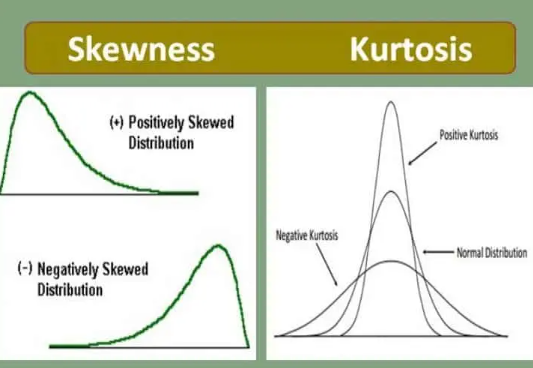

#### **NB**: Hair et al. (2010) and Bryne (2010) argued that data is considered to be normal if skewness is between ‐2 to +2 and kurtosis is between ‐7 to +7

In [20]:
# get  all the data in one DF as this will give us a full view of the data 
all_data = pd.concat((df_train.drop(target,axis =1), df_test), axis =0).reset_index(drop = True)

In [21]:
# We concatenate test data to train to get a full view of the data as we know it
skew_df = all_data.skew(numeric_only=True).sort_values()
print("Skewly distributed columns by skewness value:\n") 
display(skew_df)

Skewly distributed columns by skewness value:



is_generated                -2.620278
FineAggregateComponent      -0.420203
WaterComponent              -0.225097
CoarseAggregateComponent    -0.081940
CementComponent              0.349792
BlastFurnaceSlag             1.096469
FlyAshComponent              1.198400
SuperplasticizerComponent    1.364699
AgeInDays                    2.800024
dtype: float64

In [22]:
kurtosis_df = all_data.kurtosis().sort_values()
print("Tailed columns by kurtosis value\n") 
display(kurtosis_df)

Tailed columns by kurtosis value



CoarseAggregateComponent    -0.564362
CementComponent             -0.544868
FlyAshComponent             -0.168501
BlastFurnaceSlag            -0.041825
FineAggregateComponent       0.025898
WaterComponent               0.720646
SuperplasticizerComponent    2.169247
is_generated                 4.866827
AgeInDays                    8.874024
dtype: float64

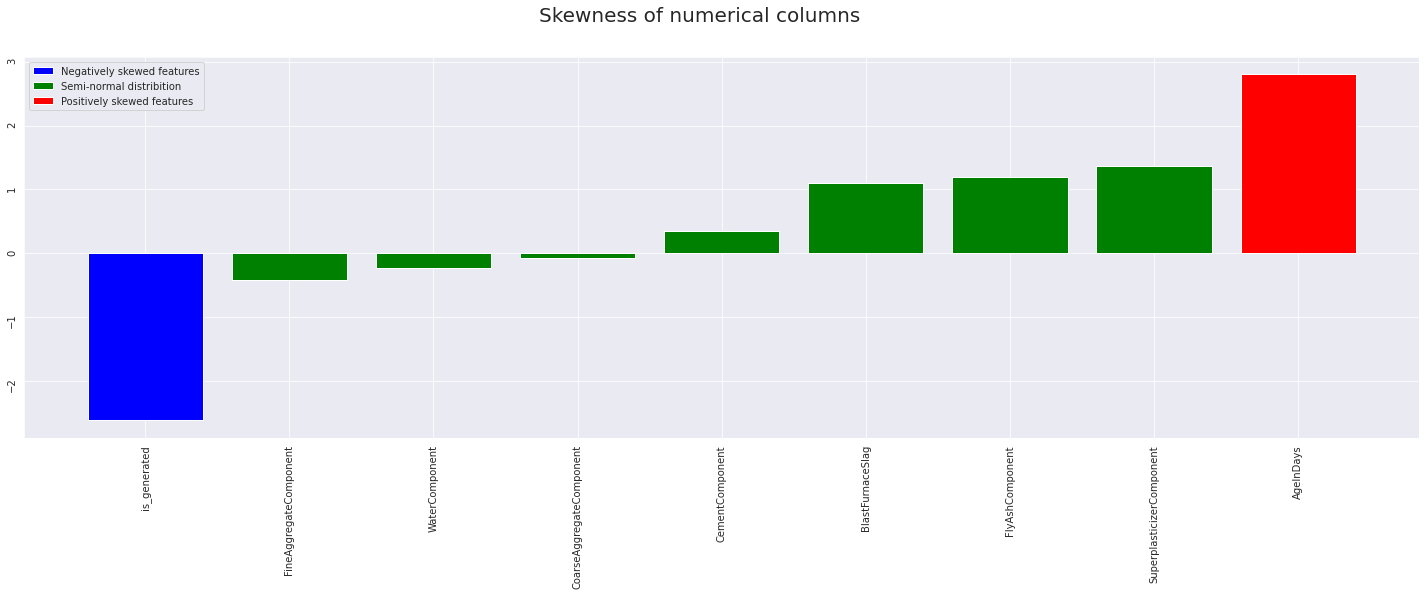

In [23]:
fig,ax = plt.subplots(figsize=(25,7))

ax.bar(x = skew_df[skew_df<-2].index, height = skew_df[skew_df<-2], color = "b", label = "Negatively skewed features")
ax.bar(x = skew_df[(skew_df<2)& (skew_df>-2)].index, height = skew_df[(skew_df<2)& (skew_df>-2)], color = "g", label= "Semi-normal distribition")
ax.bar(x = skew_df[skew_df>2].index, height = skew_df[skew_df>2], color = "r", label = "Positively skewed features")

ax.legend()
fig.suptitle("Skewness of numerical columns",fontsize = 20)
ax.tick_params(labelrotation=90)

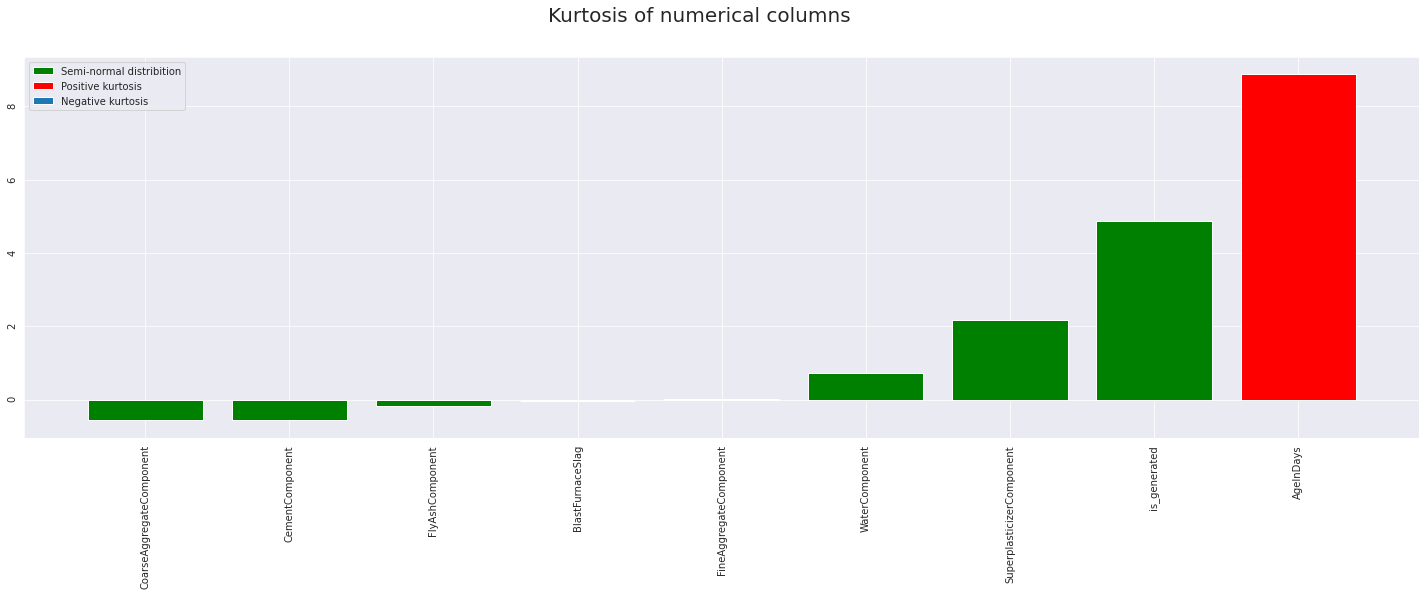

In [24]:
fig,ax = plt.subplots(figsize=(25,7))

ax.bar(x = kurtosis_df[(kurtosis_df<7)& (kurtosis_df>-7)].index, height = kurtosis_df[(kurtosis_df<7)& (kurtosis_df>-7)], color = "g", label= "Semi-normal distribition")
ax.bar(x = kurtosis_df[kurtosis_df>7].index, height = kurtosis_df[kurtosis_df>7], color = "r", label = "Positive kurtosis")
ax.bar(x = kurtosis_df[kurtosis_df<-7].index, height = kurtosis_df[kurtosis_df<-7], color = "b",  label = "Negative kurtosis")
ax.legend()
fig.suptitle("Kurtosis of numerical columns",fontsize = 20)
ax.tick_params(labelrotation=90)

<blockquote style="margin-right:auto; margin-left:auto; background-color: #9debb2; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Notes on Distribution (Skewness and Kurtosis)  </span></b>
    
* The degree of distibution of data further for a normal distribution will affect certain model performance (specifically linear models) 
* As such we need to try correct this feattures that have positive / negative kurtosis and skewness


# 👨🏼‍🌾 Distribution Transformations: 👨🏼‍🌾
* Log transform 
* Scaling (Quantile) 
* BoxCox 
* Cube root / Square root

In [25]:
non_dist_cols = np.unique( list(skew_df[(skew_df>2)|(skew_df<-2)].index) + list(kurtosis_df[(kurtosis_df>7)| (kurtosis_df<-7)].index ))
non_dist_cols

array(['AgeInDays', 'is_generated'], dtype='<U12')

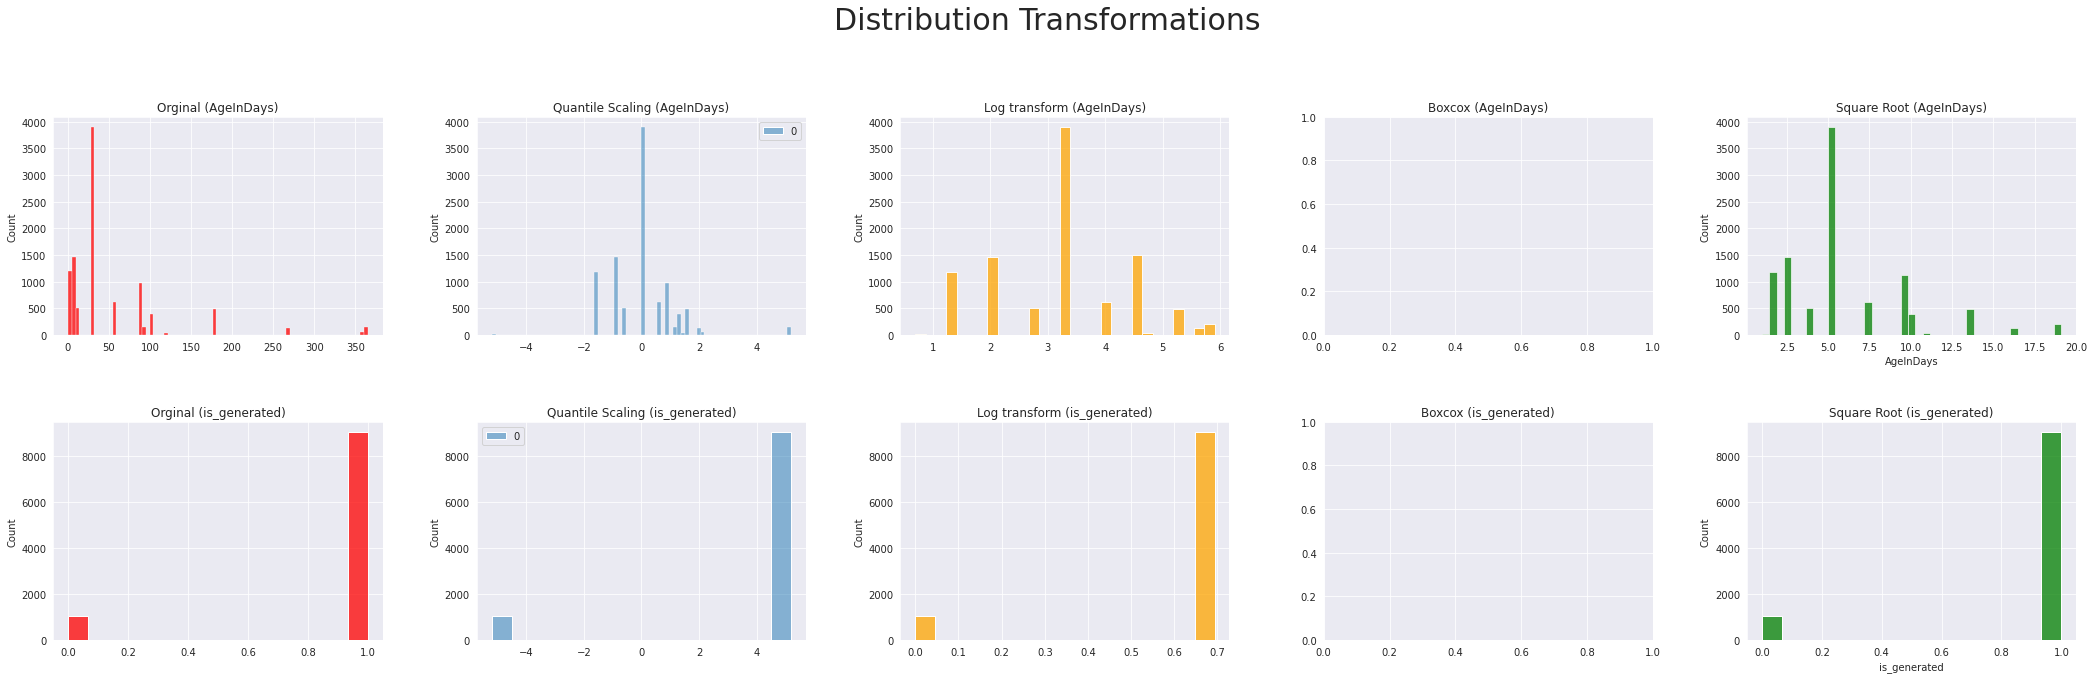

In [26]:
fig,ax = plt.subplots(len(non_dist_cols),5, figsize = (30,10))
for i,col in enumerate(non_dist_cols):
    #scale
    scaler = QuantileTransformer(output_distribution="normal")
    quant_df = scaler.fit_transform(all_data[[col]])

    sns.histplot(x= all_data[col],ax= ax[i,0], color = "r")
    sns.histplot(quant_df,ax= ax[i,1] )
    sns.histplot(np.log1p(all_data[col]), ax = ax[i,2], color= "orange")
    try:
        sns.histplot(boxcox(all_data[col], 0.15)[0], ax = ax[i,3], color= "orange")
    except:
        pass
    sns.histplot(np.sqrt(all_data[col]), ax = ax[i,4], color= "green")
    ax[i,0].set_title(f"Orginal ({col})")
    ax[i,0].set(xlabel=None)
    ax[i,1].set_title(f"Quantile Scaling ({col})")
    ax[i,2].set_title(f"Log transform ({col})")
    ax[i,2].set(xlabel=None)
    ax[i,3].set_title(f"Boxcox ({col})")
    ax[i,4].set_title(f"Square Root ({col})")
plt.suptitle("Distribution Transformations",fontsize = 30)
plt.tight_layout(pad = 4)
plt.show()

In [27]:
if ADD_DATA:
    non_dist_cols = np.delete(non_dist_cols,np.where(non_dist_cols == "is_generated"))

<blockquote style="margin-right:auto; margin-left:auto; background-color: #9debb2; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Notes:  </span></b>
    
* We are looking for the best process to create a normally distributed graphs
* From the above we see that **QuantileScaling** or **log transform** is the best process for most of the features as this gives us a nice bell shaped curve. 

**NB** Quantile Scaling will always be a good scaling process for these distributions if we assume they are non-parametric. However Age should be parametric so I will try **log transformation** instead

# 🤜🏼 Train vs Target 🤛🏼

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


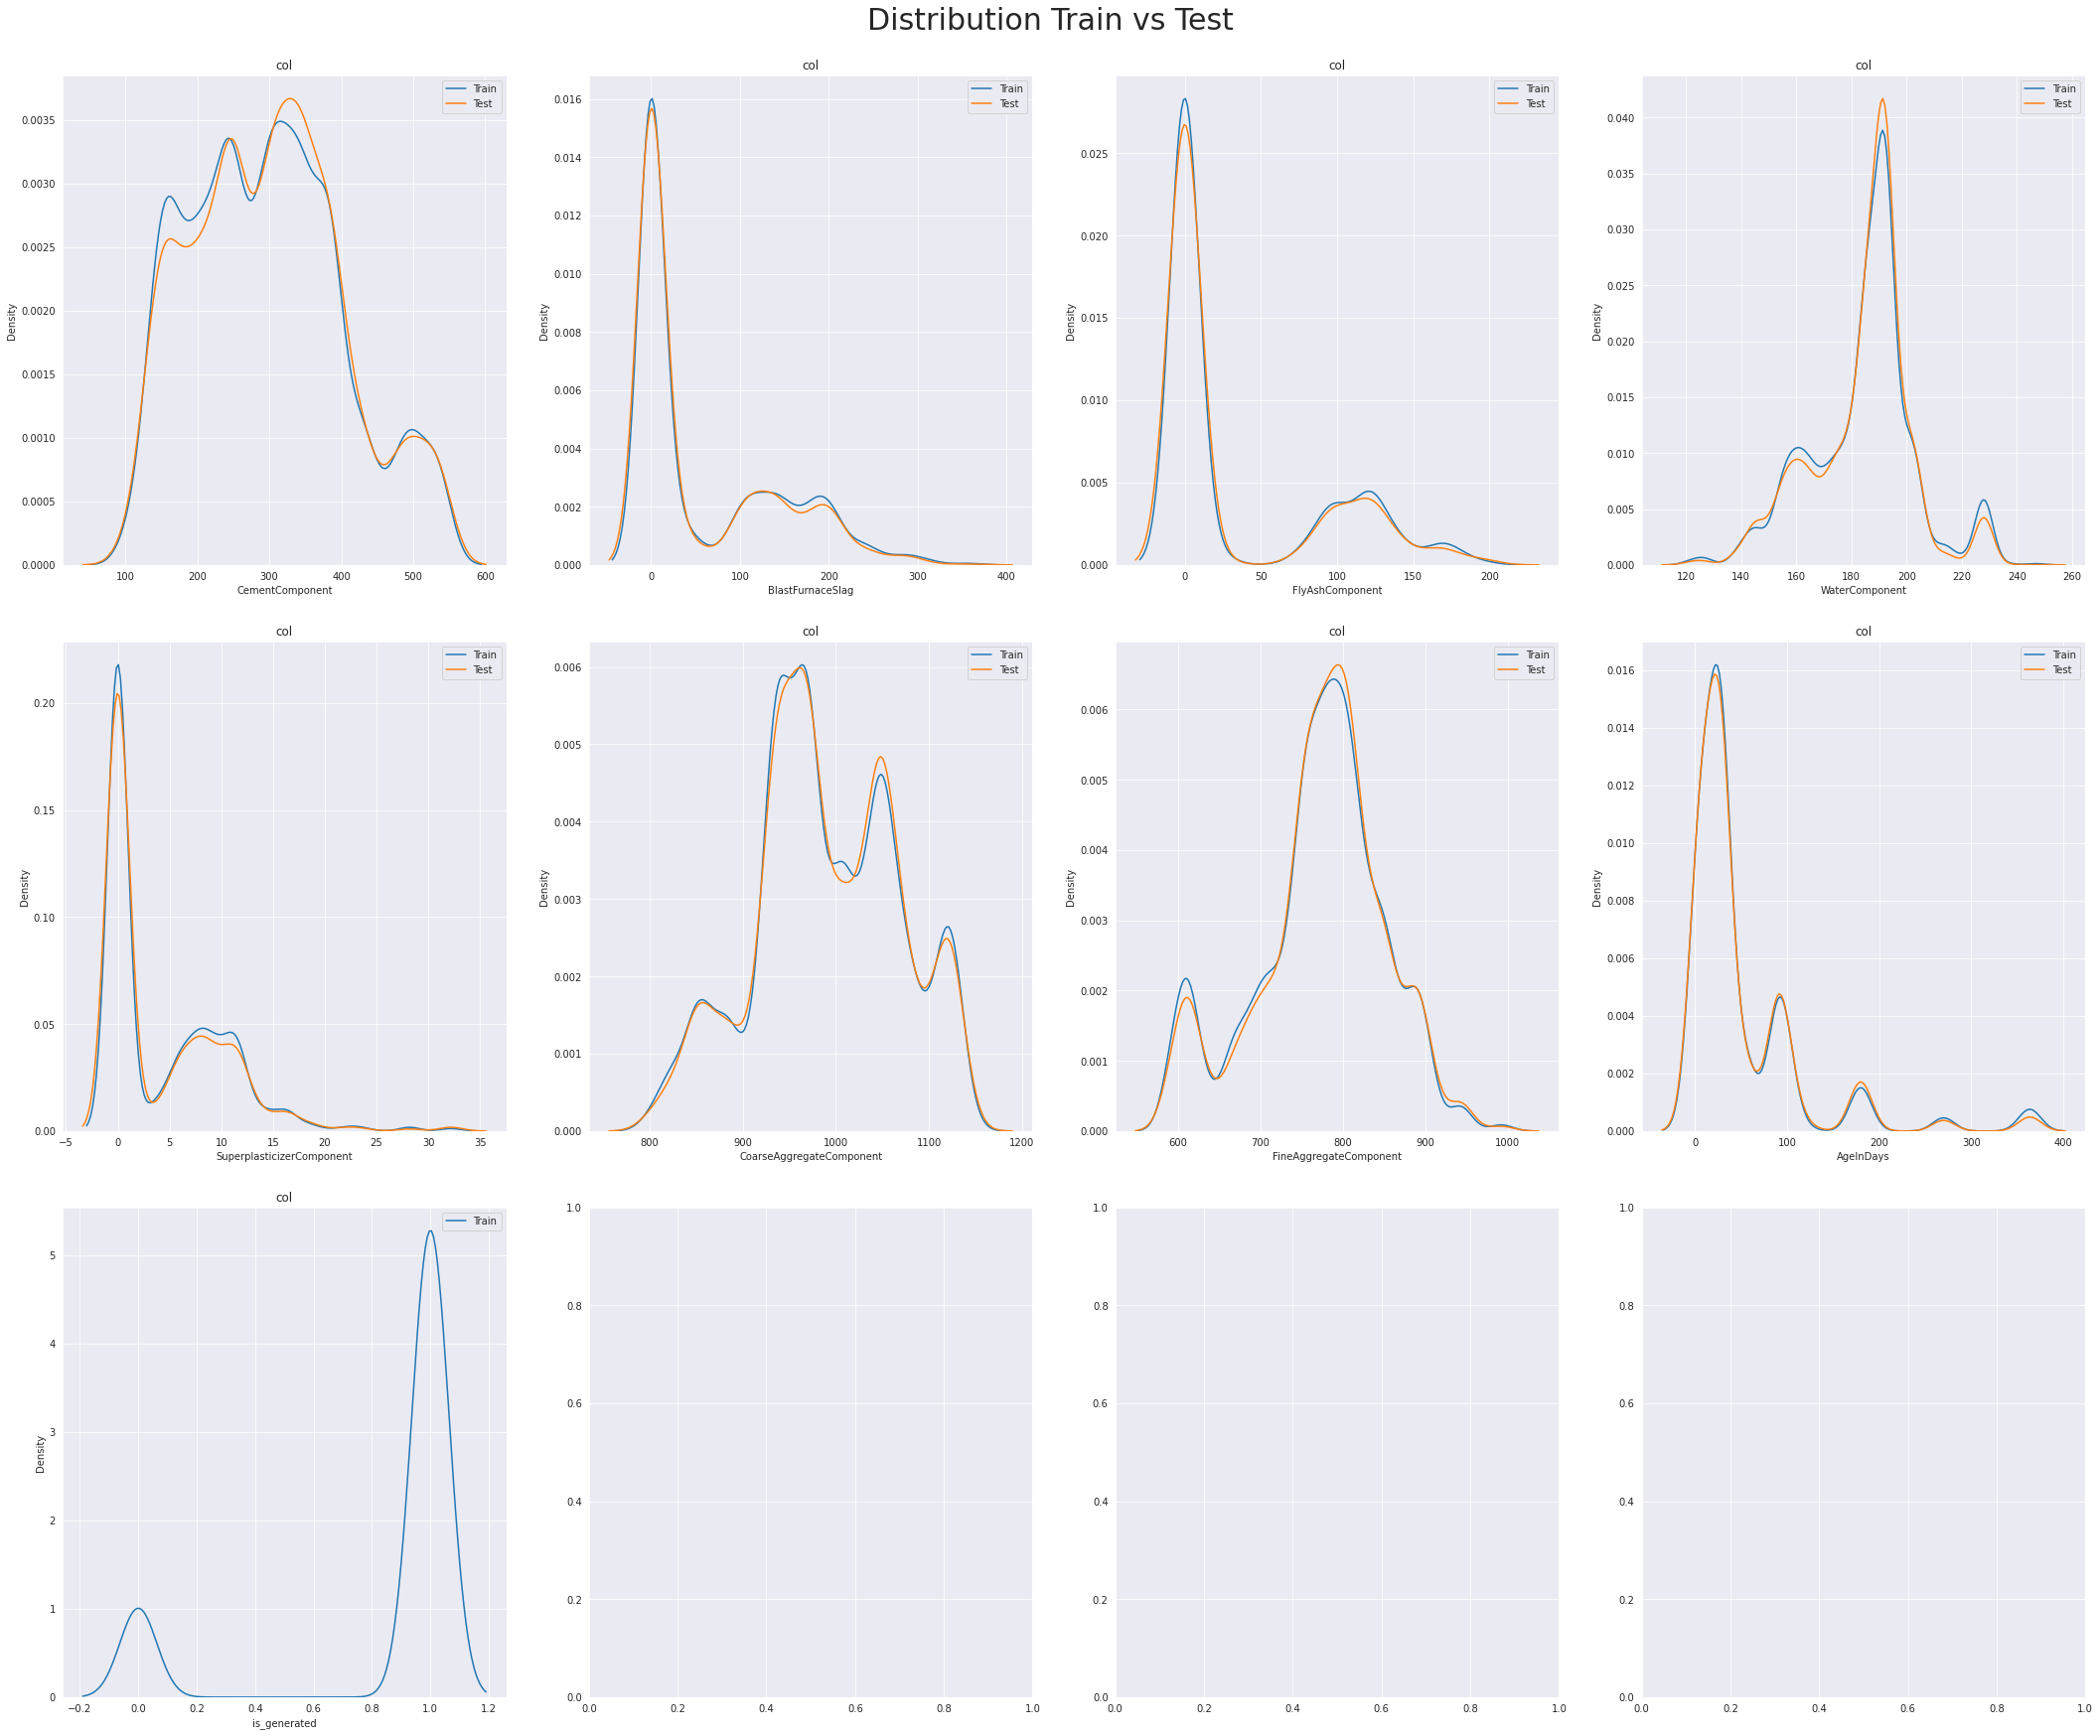

In [28]:
fig,ax = plt.subplots(int(np.ceil(len(df_test.columns)/4)),4, figsize = (30,25))
for i,col in enumerate(df_test.columns):
    ax = np.ravel(ax)

    sns.kdeplot(x= df_train[col] , label = 'Train', ax = ax[i])
    sns.kdeplot(x= df_test[col], label = 'Test', ax = ax[i] )
    
    ax[i].legend()
    ax[i].set_title(f"col")

plt.suptitle("Distribution Train vs Test",fontsize = 30)
plt.tight_layout(pad =3)
plt.show()

<blockquote style="margin-right:auto; margin-left:auto; background-color: #9debb2; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Train vs Test Distribution  </span></b>
    
* The distribution of Test and Train datasets seem to align, this bodes well for our submission as we want our model to train on a dataset that is similar to the prediction dataset (i.e. test)


## Predict if its Train or Test?
* Can we distinguish the difference between train or test data
* If we can then we need to check where these differences are to align our datasets 

In [29]:
if ADD_DATA:
    df_trn = df_train[df_train["is_generated"]==1].copy(deep = True).drop("is_generated",axis =1)
    df_tst = df_test.copy(deep = True).drop("is_generated",axis =1)
else:
    df_trn = df_train.copy(deep = True)
    df_tst = df_test.copy(deep = True)

In [30]:
df_trn["is_train"] =1
df_tst["is_train"] =0

df_train_vs_test = pd.concat([df_trn.drop(target,axis =1),df_tst],axis =0)
df_train_vs_test

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,is_train
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,1
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,1
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,1
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,1
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,1
...,...,...,...,...,...,...,...,...,...
9007,140.0,129.0,100.0,200.0,7.0,864.0,753.0,28,0
9008,281.0,0.0,0.0,186.0,0.0,1104.0,774.0,28,0
9009,289.0,133.0,0.0,194.0,7.0,924.0,760.0,28,0
9010,469.0,117.2,0.0,137.8,32.2,852.1,840.5,3,0


In [31]:
X = df_train_vs_test.drop(["is_train"],axis =1)
y = df_train_vs_test["is_train"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model= lgb.LGBMClassifier()
model.fit(X_train,y_train,
      eval_set=[(X_test,y_test)],
      eval_metric="auc",
      callbacks= [lgb.log_evaluation(-1), lgb.early_stopping(30)])

val_preds = model.predict_proba(X_test)[:,1]
trn_preds = model.predict_proba(X)[:,1]

score_trn =roc_auc_score(y, trn_preds)
score_val = roc_auc_score(y_test, val_preds )

print("\nTrn auc Score:",score_trn)
print("Val auc Score:",score_val)

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.513369	valid_0's binary_logloss: 0.670042

Trn auc Score: 0.5605188938056616
Val auc Score: 0.5133693908433077


<blockquote style="margin-right:auto; margin-left:auto; background-color: #9debb2; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Note:  </span></b>

* AUC is close to 0.5 therefore we can conclude that Train and Test datasets are "relatively" similar and we can assume our models trained on the training data will be able to predict the test data 

# 🧩 Correlation 🧩
* Features that contain similar (correlated / mutual) information negatively impact certain models as this can cause **overfitting** with linear models 
* **Features** that are correlated to **Target** will improve our models predictions

<blockquote style="margin-right:auto; margin-left:auto; background-color: #9debb2; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Note:  </span></b>

* Note that decision trees 'generally' arent affected by highly correlated features as they will choose the best feature that provides the highest information gain. unless there is some feature selection parameter:
 * Random forests could be afftected by highly correlated features as they might incorrectly select the correlated feature with less information gain 

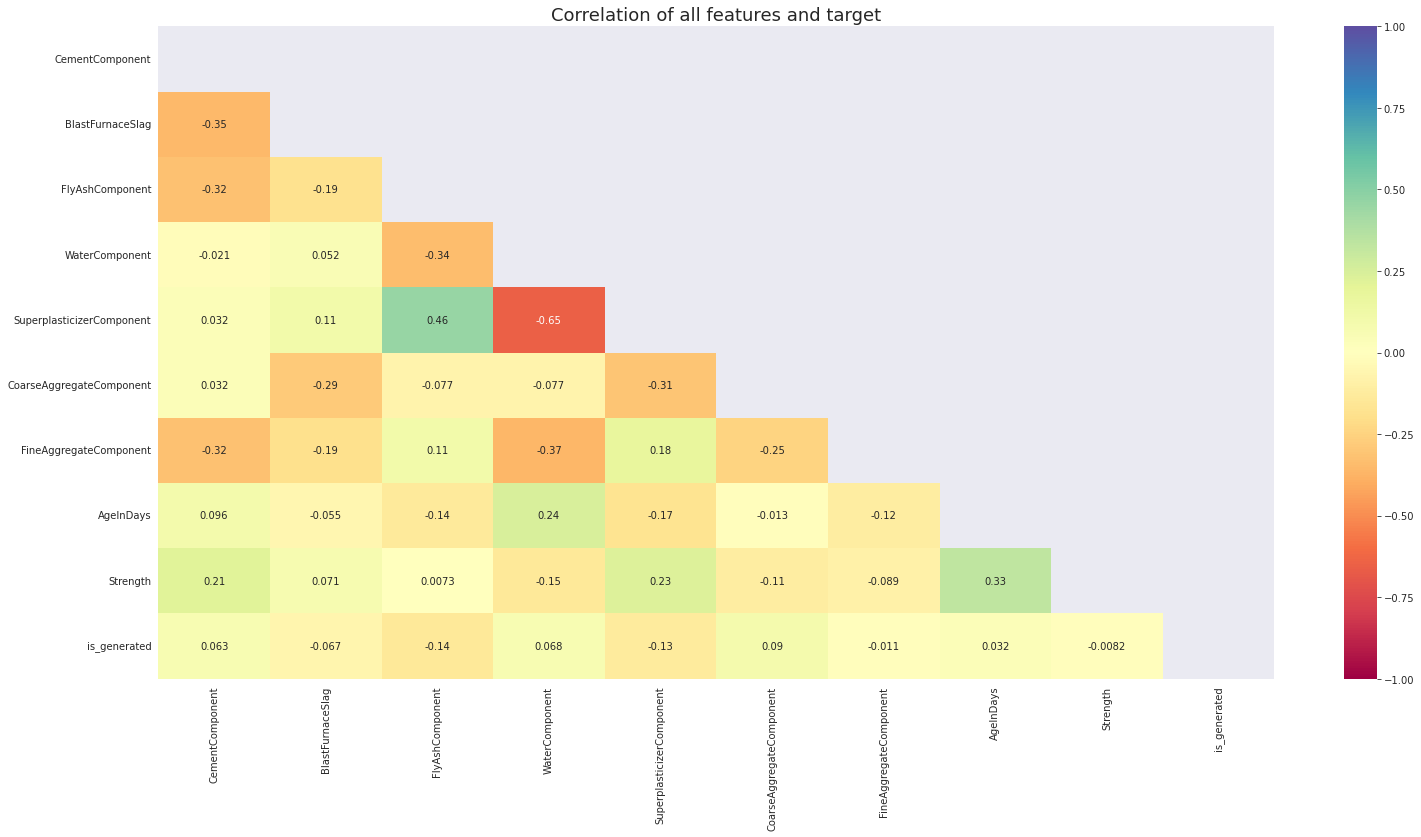

In [32]:
plt.figure(figsize = (25,12))

corr = df_train.corr()
upper_triangle = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr,vmin = -1, vmax = 1, cmap = "Spectral", annot = True, mask = upper_triangle)
plt.title("Correlation of all features and target", fontsize= 18)
plt.show()

<blockquote style="margin-right:auto; margin-left:auto; background-color: #9debb2; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Notes on Correlation  </span></b>

#### Target Correlation
 * No large correlation between target and features which is unfortunate as highly correlated features to the target would improve model accuracy
 * Will feature engineering of other features result in more correlation i.e. AgeinDays x SuperplasticizerComponent
    
#### Feature Correlation 
* SuperplasticizerComponent and WaterComponent are highly correlated --> we should potentially look at decomposition to remove correlation as this may cause overfitting 

### 🎇 Feature Engineering & Selection 🎇
There are a number of processes and algorithms that can help us select features before we train our model. A quick pre-training excercise is to look at highly correlated features and apply mathematical operations to them to see if they result in a feature that highly correlates to the Target 

Note that most feature selection techniques are post training,they include:
* [Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV) 
* [Model importance ](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel)
* [Sequential Feature Selection ](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector)

Below we will look at trying to create new features that are highly correlated with the Target. We will start with features that are individually correlated already 

In [33]:
# for i, col in enumerate([col for col in df_test.columns if col not in ["squareMeters"]]):
#     df_train[f"sqr_add_{col}"] = df_train["squareMeters"] + df_train[col]
#     df_test[f"sqr_add_{col}"] = df_test["squareMeters"] + df_test[col]

In [34]:
# plt.figure(figsize = (25,12))
# corr = df_train.corr()
# upper_triangle = np.triu(np.ones_like(corr, dtype=bool))

# sns.heatmap(corr,vmin = -1, vmax = 1, cmap = "Spectral", annot = True, mask = upper_triangle)
# plt.title("Correlation of all features and target", fontsize= 18)
# plt.show()

<blockquote style="margin-right:auto; margin-left:auto; background-color: #9debb2; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Note:  </span></b>
    
* To come back to this section 

# 🦠 Outliers / Distribution 🦠
* Outliers will skew certain models and result in poor local optimums in trained models and reduce model performance. As such we need to assist our models in identifying outliers:
* We will identify features with a large number of outliers through:
    * Boxplots visualization
    * zscore analysis (we can calculate each samples standard deviation from the feature mean)

<blockquote style="margin-right:auto; margin-left:auto; background-color: #9debb2; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Note:</span></b>
    
* Decision Trees are robust towards outliers as they try best partition the data. Outliers should be resolved for linear models as this will negatively affect them

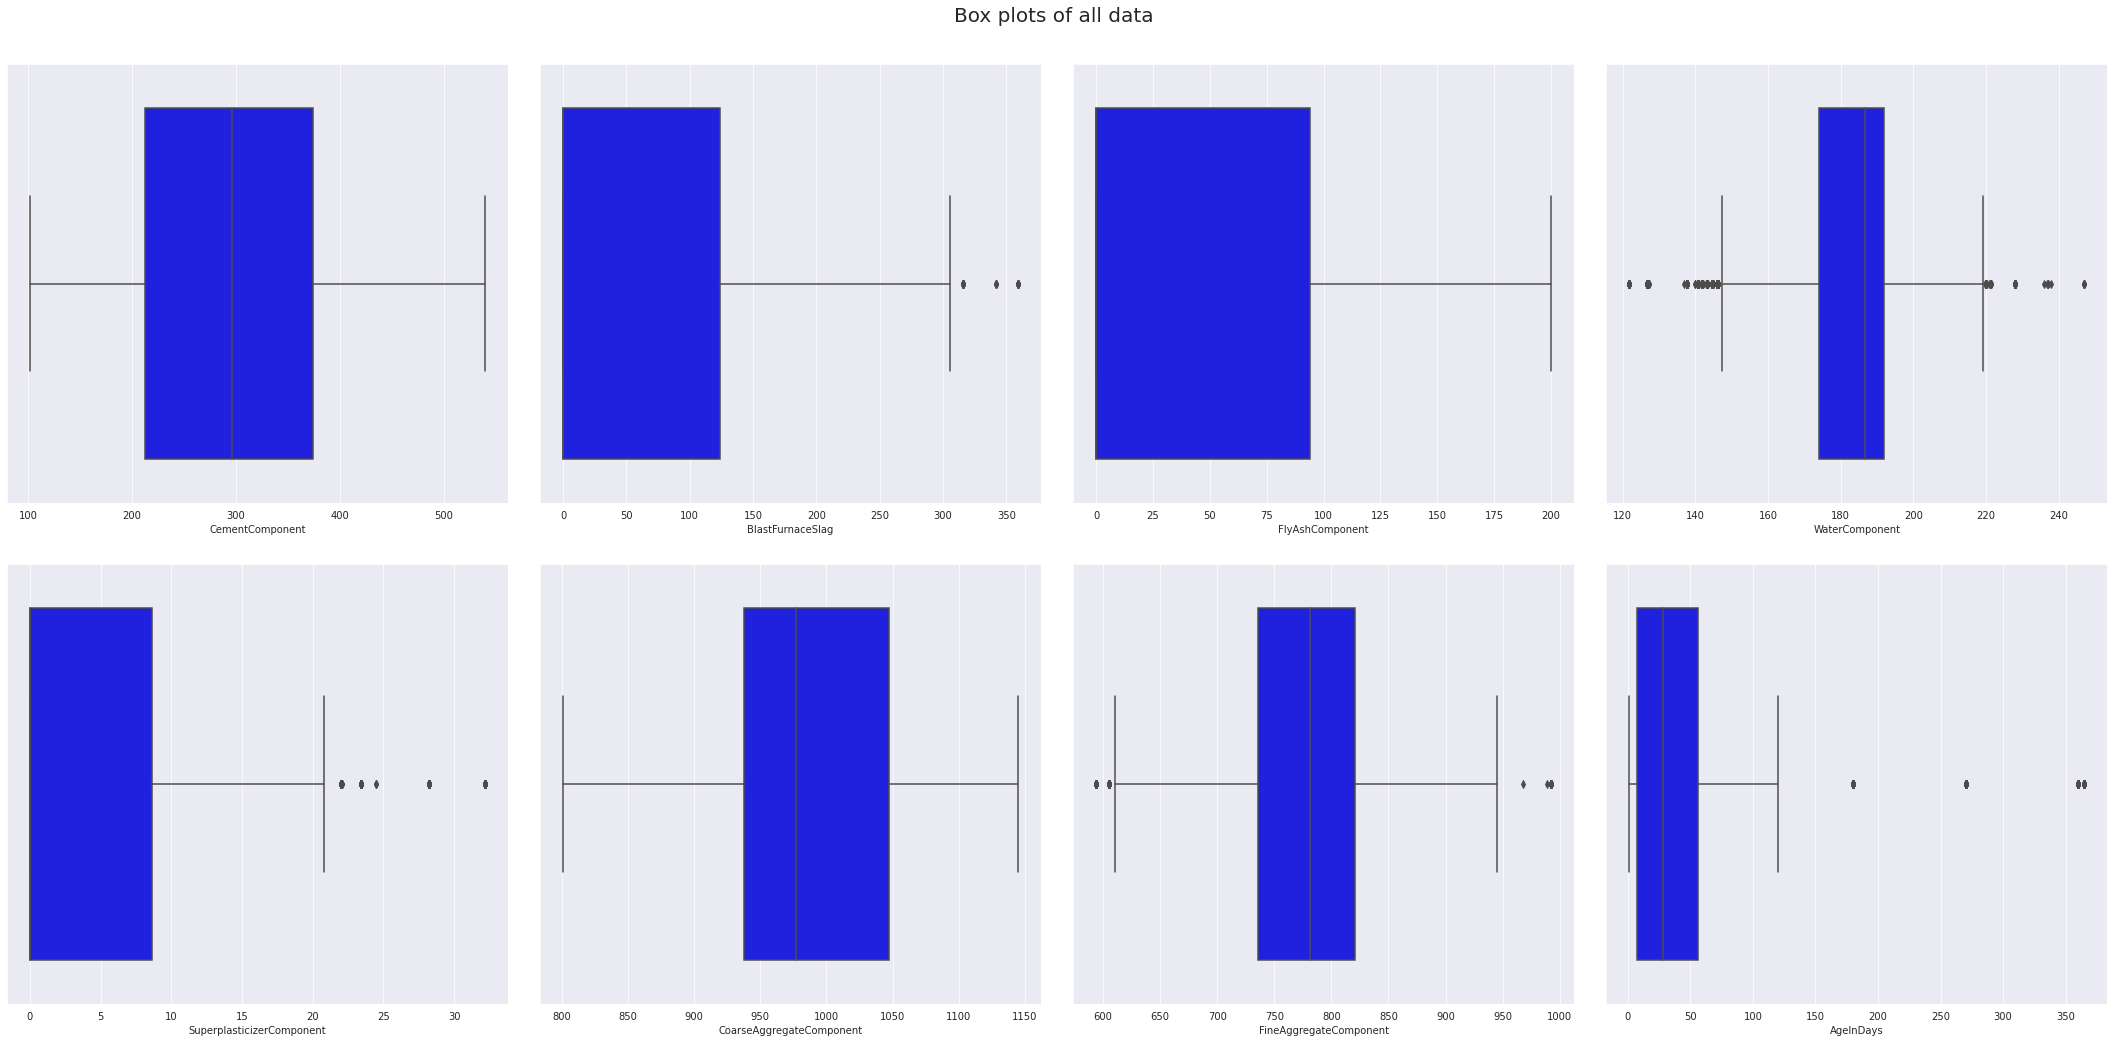

In [35]:
fig,ax = plt.subplots(int(np.ceil(len(numerical)/4)),4,figsize = (30,15))
ax = np.ravel(ax)

for i,col in enumerate(numerical):
    sns.boxplot(ax = ax[i], x = all_data[col], color= "blue")

fig.suptitle("Box plots of all data ",fontsize = 20)
plt.tight_layout(pad=3)
plt.show()

In [36]:
from scipy.stats import zscore
df_zscores = pd.concat((df_train.drop(target,axis =1), df_test), axis =0)[numerical].apply(zscore)
print("Sample z-scores by feature:\n")
df_zscores.head()

Sample z-scores by feature:



,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays
0,2.159484,-0.713030,-0.612420,0.082842,-0.751204,1.754498,-2.036960,-0.703440
1,-1.468149,1.323490,1.925647,0.350786,0.628973,-0.289905,-1.654371,-0.330810
2,-0.081672,0.910161,-0.612420,0.066766,-0.751204,1.107535,0.287905,-0.330810
3,0.060775,0.202801,-0.612420,2.333573,-0.751204,-0.742779,-1.310041,4.692239
4,-1.335199,2.130867,-0.612420,0.404375,-0.751204,-0.698786,0.108089,0.593312


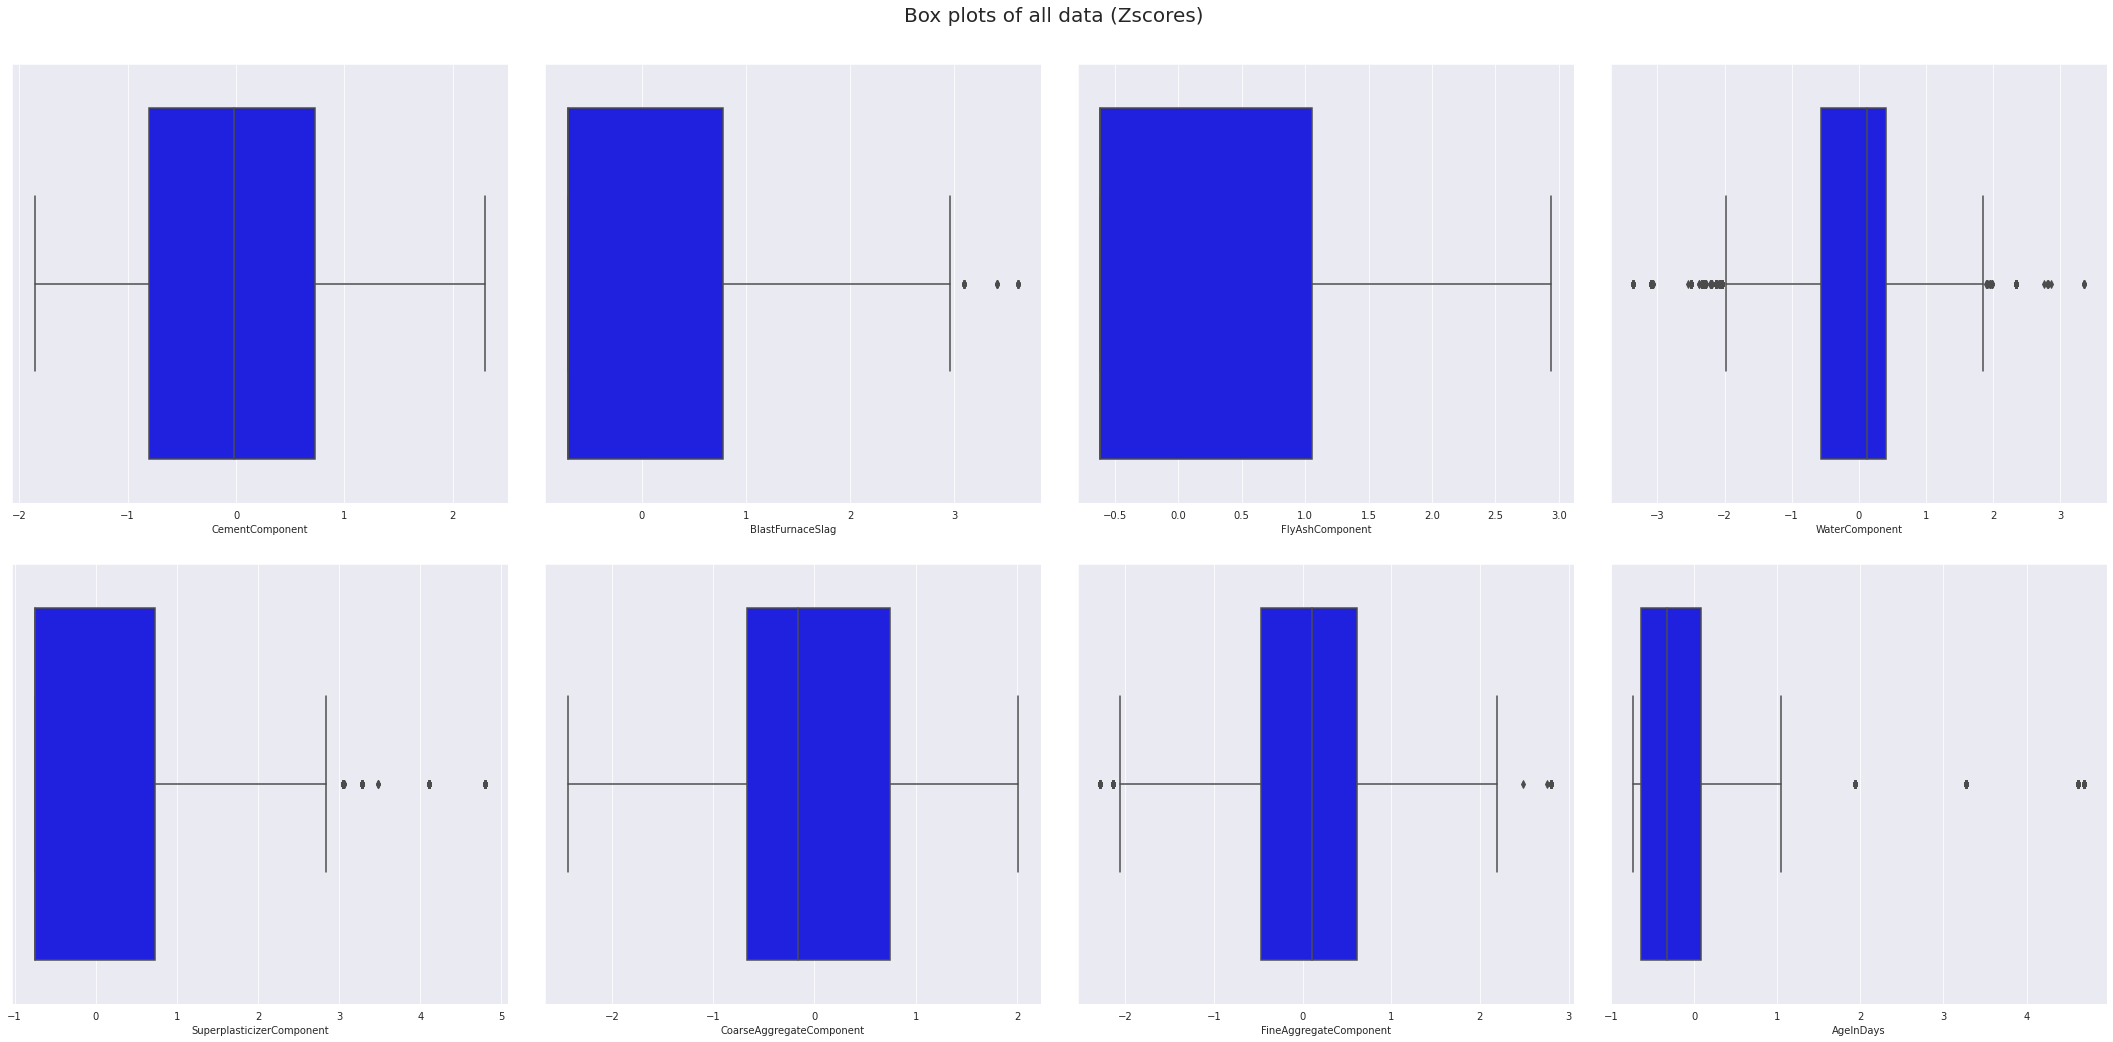

In [37]:
fig,ax = plt.subplots(int(np.ceil(len(numerical)/4)),4,figsize = (30,15))
ax = np.ravel(ax)

for i,col in enumerate(numerical):
    sns.boxplot(ax = ax[i], x = df_zscores[col], color= "blue")

fig.suptitle("Box plots of all data (Zscores) ",fontsize = 20)
plt.tight_layout(pad=3)
plt.show()

c

* Columns with a large number of outliers will skew our models. Especially Linear models (NB: Tree models shouldnt be affected)
* From eye balling the above graphs we have a number of columns with outliers
 * WaterComponent
 * SuperplasticizerComponent (slightly)
 * FineAggregateComponent (slightly)
 * AgeInDays (slightly)


In [38]:
outliers = ['WaterComponent'] # 'SuperplasticizerComponent', 'AgeInDays', 'FineAggregateComponent'

# 🎯 Feature Engineering 🎯
* Feature engineering is the most complex part of data science as this requires certain domain knowledge as well as trial and error. 
* This is usually an iterative process by adding/ removing features and training and analysing models 
* We will leave leave this section bare for now 

In [39]:
df_trn = df_train.copy(deep = True)
df_tst = df_test.copy(deep = True)
df_trn

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,is_generated
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,1
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,1
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,1
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,1
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,1
...,...,...,...,...,...,...,...,...,...,...
6432,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,0
6433,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18,0
6434,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70,0
6435,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77,0


In [40]:
def add_features(df_in):
    df = df_in.copy(deep = True)
    
    return df

df_trn = add_features(df_trn)
df_tst = add_features(df_tst)

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:2px;">
<span style="color:red;font-size:1.1em;">Solution Implementation: Duplicates </span>
    
* Drop duplicates

In [41]:
# Drop duplicates in Train
print(df_trn.duplicated().sum())
df_trn.drop_duplicates(inplace = True,ignore_index  = True)
print(df_trn.duplicated().sum())

25
0


## 🧬 Encoding 🧬

<span style="color:orange;font-size:1.5em;">Solution Implementation: Encoding </span>
* Onehotencoding vs WOEencoder vs LabelEncoder

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:2px;">
<span style="color:red;font-size:1.1em;">Solution Implementation: Categorical columns </span>
    
* There doesnt seem to be any categorical  columns, therefore this section will be ignored

In [42]:
# all_data = pd.concat((df_trn.drop(target,axis =1), df_tst), axis =0).reset_index(drop = True)
# df_dummies = pd.get_dummies(all_data,drop_first =True)

## 🕵🏻Correlation reduction w/ PCA 🕵🏻
PCA is a simple methodology to remove correlation from our dataset and as such should inhibit our models from overfitting. However there is a chance that PCA will remove important information during the decomposition process

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:2px;">
<span style="color:red;font-size:1.1em;">Solution Implementation: Highly Correlated features </span>
    
* We will look at running PCA (decomposition) on the 2 correlated features identified above

In [43]:
## we will only look at certain features that are highly correlated and run pca  as incorrectly running PCA on the wrong columns could decompose important features. This is therefore a trial and error exercise 

if PCA_run: 
    pca_cols = ["WaterComponent", 'SuperplasticizerComponent']
    pca_ = PCA(n_components=1 ,whiten= False)
    df_trn["pca_1"] = pca_.fit_transform(df_trn[pca_cols])
    df_tst["pca_1"] = pca_.fit_transform(df_tst[pca_cols])

    # drop oroginal columns:
    for df in [df_trn,df_tst]:
        df.drop(pca_cols, axis =1, inplace = True)
else: 
    pca_cols = []

df_trn

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,is_generated
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,1
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,1
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,1
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,1
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,1
...,...,...,...,...,...,...,...,...,...,...
6407,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,0
6408,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18,0
6409,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70,0
6410,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77,0


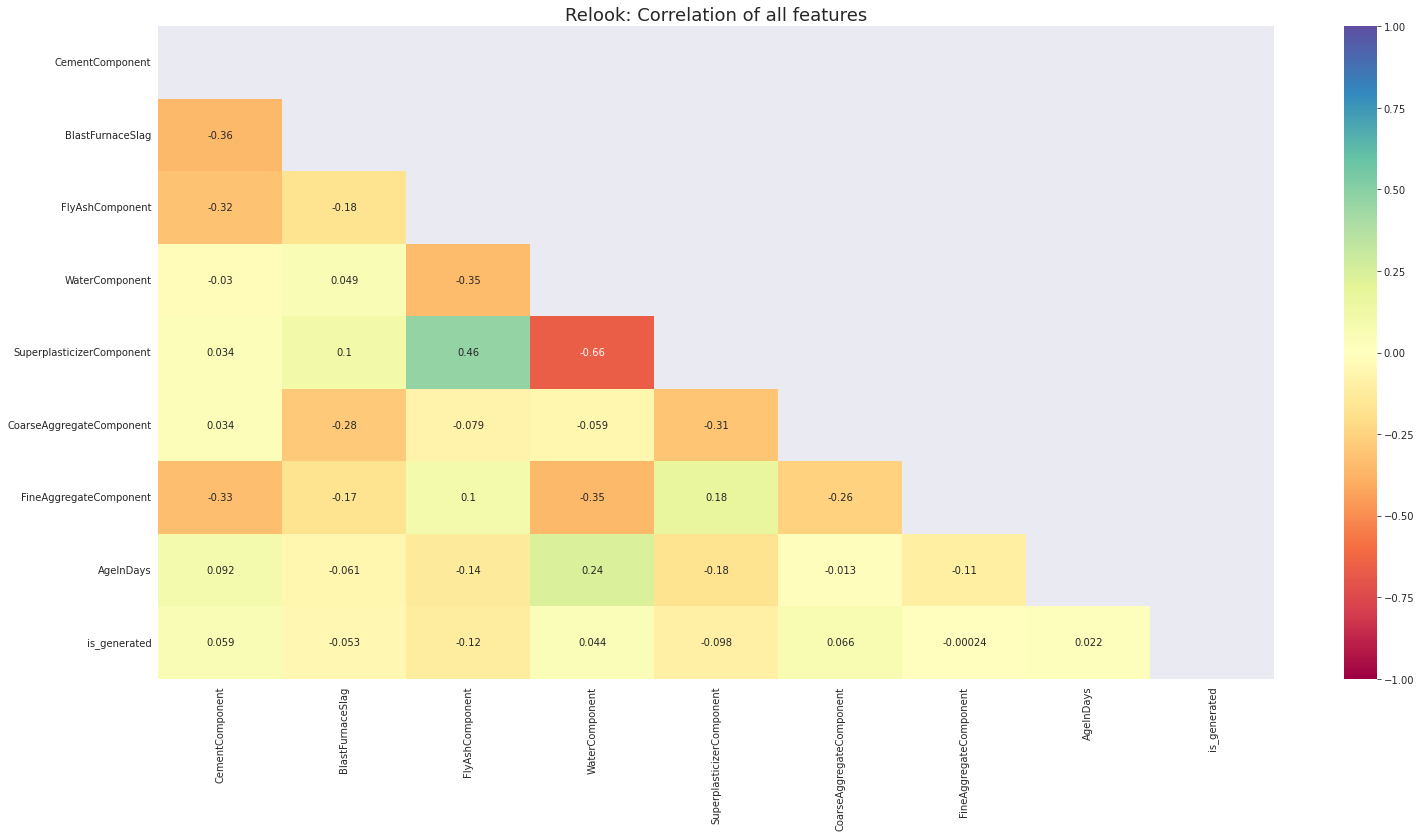

In [44]:
plt.figure(figsize = (25,12))
corr = pd.concat((df_trn.drop(target,axis =1), df_tst), axis =0).corr()
upper_triangle = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr,vmin = -1, vmax = 1, cmap = "Spectral", annot = True, mask = upper_triangle)
plt.title("Relook: Correlation of all features", fontsize= 18)
plt.show()

## Split

In [45]:
X = df_trn.drop([target],axis =1)
y = df_trn[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# 🧊 Basic Modelling 🧊
We run a basic model for testing in order to:
* Quickly confirm any changes made to our code 
* Quickly check if additional features/processes cause large changes in our models score 
* Evaluate feature importance

Note: I wont be scaling the values here as it makes it hard to understand our feature values in visualizations later on

State our base model paramaters 

In [46]:
lgb_params ={'objective': 'regression',# regression_l1, huber, fair, poisson, quantile, mape, gamma, tweedie
             "metric":"rmse", 
             "boosting_type": "gbdt",#"dart",gbdt
#              'lambda_l1': 1.0050418664783436e-08, 
#              'lambda_l2': 9.938606206413121,
#              'num_leaves': 44,
#               'feature_fraction': 0.8247273276668773,
#               'bagging_fraction': 0.5842711778104962,
#             'bagging_freq': 6,
#              'min_data_in_leaf': 134,
#              'min_child_samples': 70,
#              'max_depth': 8,   
             'n_estimators':EPOCHS,
             'learning_rate':0.01,
            'device':'cpu',
            "verbose": -1}

In [47]:
# We want to only validate our model on the competition data (not the added data)
if TEST_ON_GENERATED_ONLY:
    index_val = X_test[X_test["is_generated"]==1].index
    y_test = y_test[index_val]
    X_test = X_test.loc[index_val, :]

In [48]:
model= lgb.LGBMRegressor(**lgb_params)
test_preds_base, trn_preds_base, val_preds_base, score_trn, score_val = base_model(X_train,y_train,X_test,y_test, "lightgbm",model, X, df_tst)

print("\nSMAPE",SMAPE(y_test, val_preds_base))
print("R-squared",r2_score(y_test, val_preds_base))


Trn Score: 10.92204261930127
Val Score: 12.206957565320234

SMAPE 29.205191029955063
R-squared 0.428786949075187


# 📊 Model Performance (Residual Analysis and Scores) 📊
Here we look at the performance of our model using the scores above and investigate the residuals\
This will help us understand how well our model is doing

* Residual analysis (what to look for)
    * Outliers 
    * Normal distribution (centred around 0)
    * Value of residuals vs tarhet 

<blockquote style="margin-right:auto; margin-left:auto; background-color: #9debb2; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Notes on Score Analysis  </span></b>
    
* Our model did poorly in predicting the target:
    * R-squared gives us a quick indication of the models variance vs the data variance. This low score (0.4) is on a scale of 0-1 and shows that our model has a high variance vs the data variance i.e. the residuals are larger that the variance intrinsic to the data 
       * This is bad 
    * RootMeanSquare error of the validation set is 12 where our targets mean value is around 35 
        * i.e. We are approx 30% off our target value which is poor 

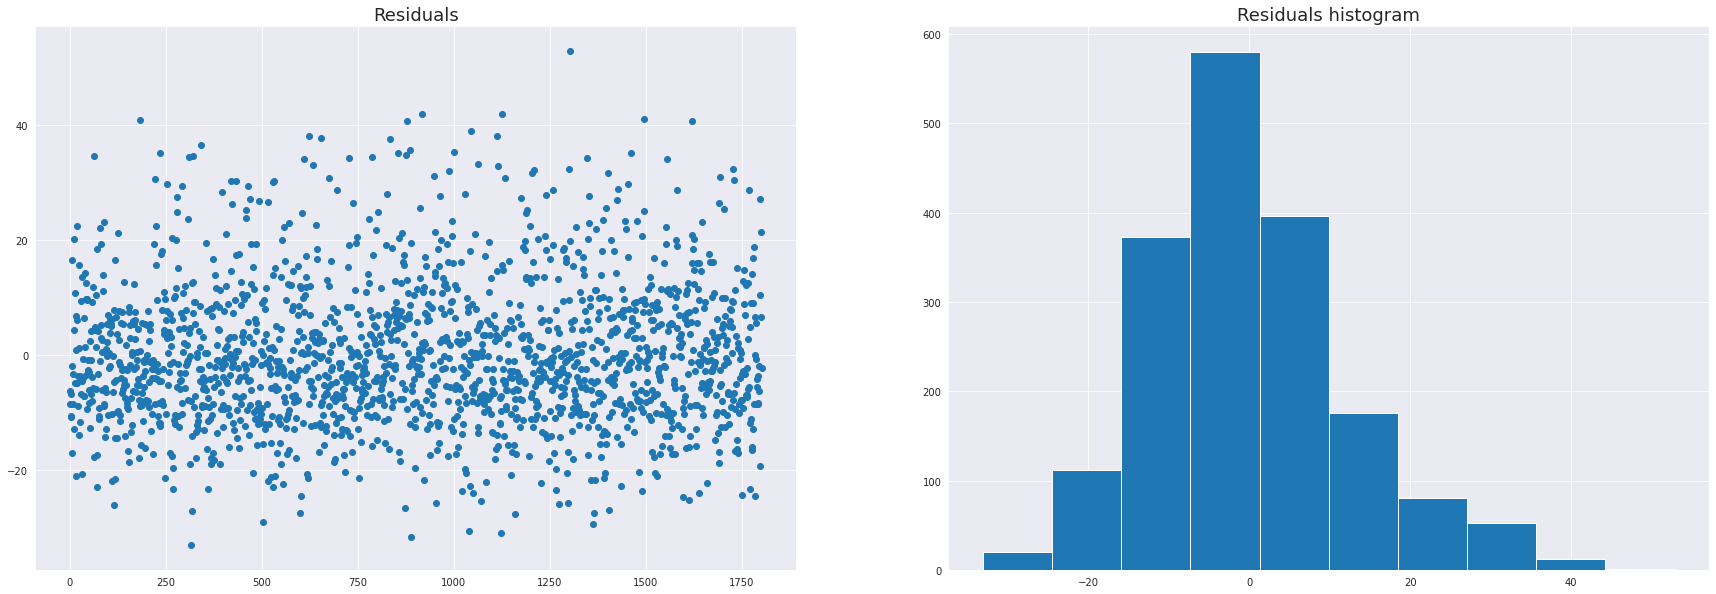

In [49]:
res = y_test - val_preds_base
fig, ax = plt.subplots(1,2, figsize = (30,10))
ax[0].scatter(x = [i for i in range(len(res))], y = res)
ax[1].hist(res)
ax[0].set_title("Residuals", fontsize= 18)
ax[1].set_title("Residuals histogram", fontsize= 18)
plt.show()

In [50]:
print( "Target relook")
df_trn.describe()[target]

Target relook


count    6412.000000
mean       35.420459
std        16.382499
min         2.330000
25%        23.640000
50%        33.945000
75%        45.710000
max        82.600000
Name: Strength, dtype: float64

<blockquote style="margin-right:auto; margin-left:auto; background-color: #9debb2; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Notes on Residual Analysis  </span></b>

* Our Residuals look uniform i.e. no massive ourliers ( however our variance is very large
* Looking at the target column stats the mean is 35 but our residuals go above and below 20 and -20 which is very poor 
    * i.e. our difference in prediction is close to the mean of the value, showing that our model isnt good at predicting the target 

# 📈 Partial Dependency Plots 📈
* Partial dependecy plots show how changes in certain features impact the target value (i.e prediction) 
* This can give us information on additional features and how our models predicts our training data

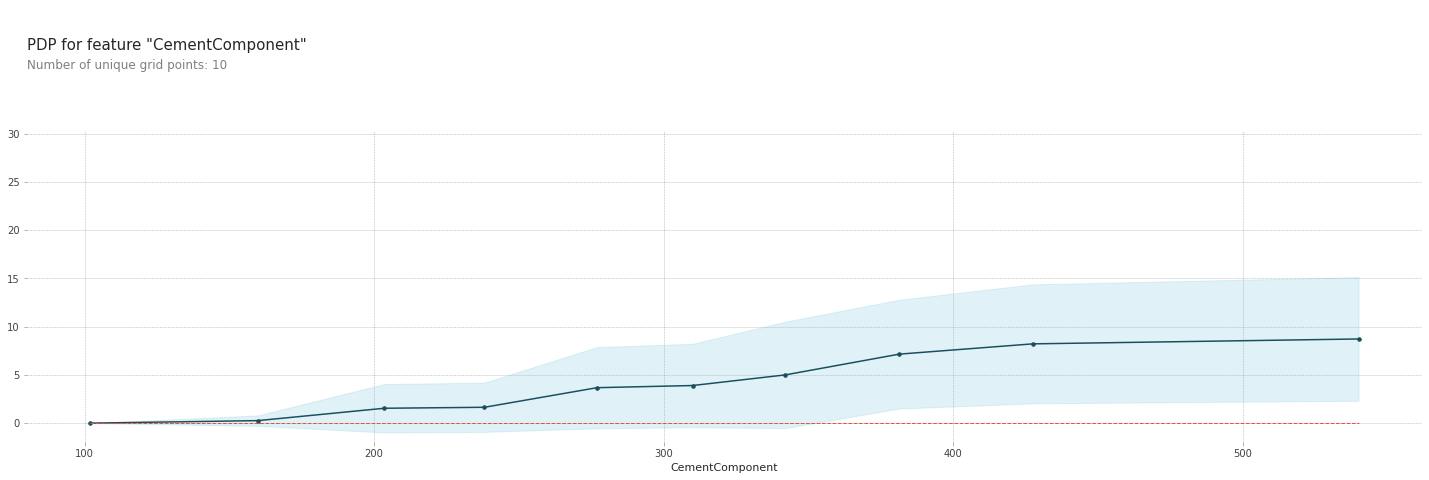

In [51]:
from pdpbox import pdp, get_dataset, info_plots
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_train
                           , model_features=X_train.columns
                           , feature='CementComponent')
pdp.pdp_plot(pdp_dist, feature_name='CementComponent',figsize =(25,8))
plt.tight_layout()
plt.show()

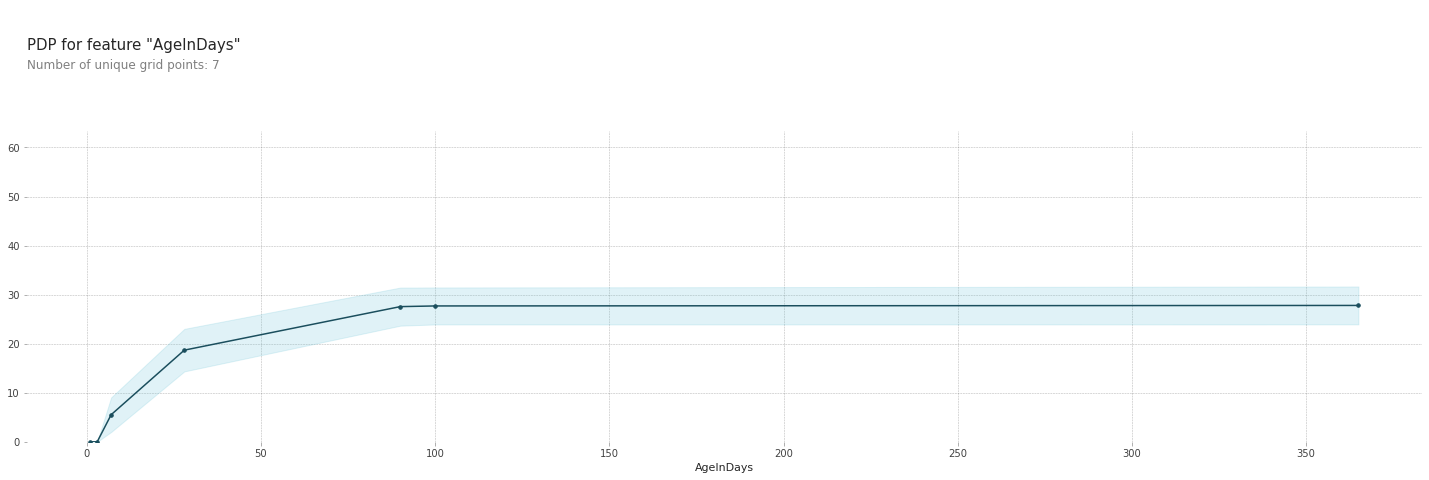

In [52]:
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_train
                           , model_features=X_train.columns
                           , feature='AgeInDays')
pdp.pdp_plot(pdp_dist, feature_name='AgeInDays',figsize =(25,8))
plt.tight_layout()
plt.show()

<blockquote style="margin-right:auto; margin-left:auto; background-color: #9debb2; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Notes: </span></b>
    
* From the above graphs we see how the target value (y axis) changes as the values of 'CementComponent' and '**AgeInDays'**  changes 
    * We can see an increase in the target as these 2 features increase
    * Therefore if we want to better predict our Housing Price we might want to further feature engineer '**CementComponent**' and '**AgeInDays'** 

# ☘️ Feature importance ☘️

## 1. Intrinsic model feature importance
* As we are using lightgbm as our base model we can get an output of the models feature importance. 

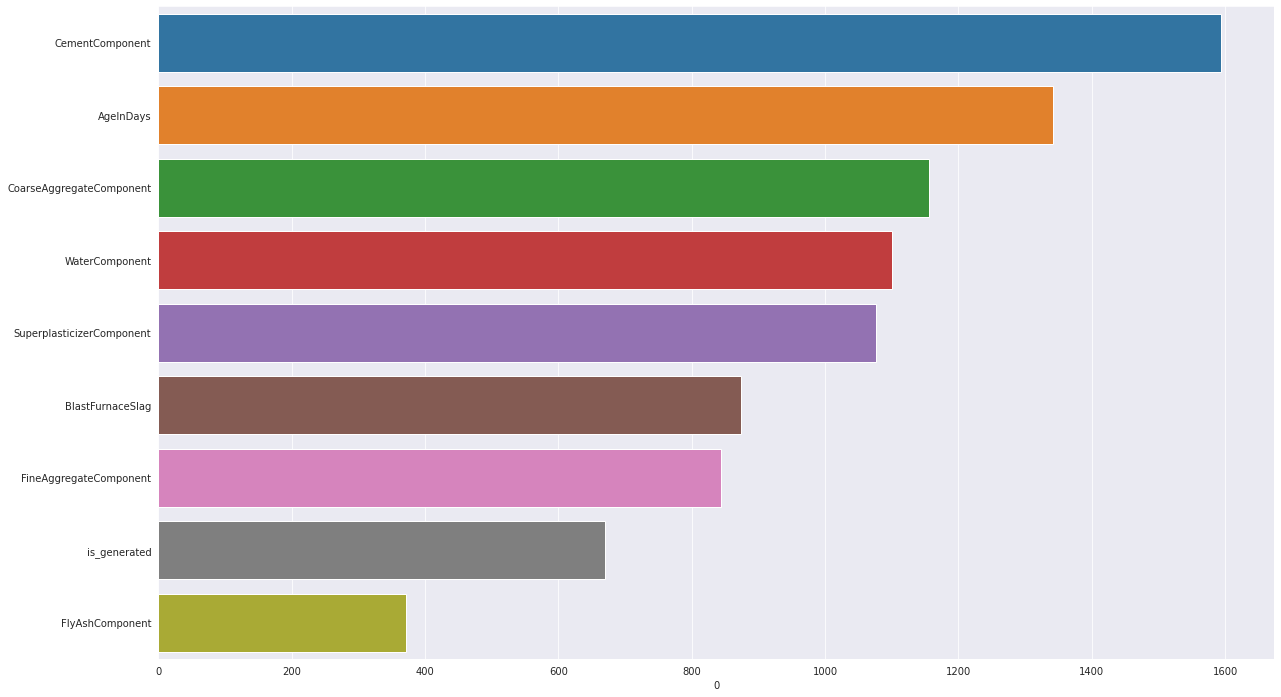

In [53]:
importances = pd.DataFrame(data = model.feature_importances_, index = model.feature_name_).sort_values(ascending = False , by =0)

plt.figure(figsize = (20,12))
sns.barplot(x = importances[0], y= importances.index)
plt.show()

<blockquote style="margin-right:auto; margin-left:auto; background-color: #9debb2; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Notes:</span></b>
    

 * All features seem to be 'important' to prediction therefore we shouldnt drop any

## 2. Shap values 
[Shap values](https://shap.readthedocs.io/en/latest/index.html) are a good indicator of the **degree of feature importance** 
* We use multiple visualization methods to assists when plotting shap values from our fitted model

 
<blockquote style="margin-right:auto; margin-left:auto; background-color: #9debb2; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Notes on Shap Values   </span></b>
    
Shape values determine how the prediction was impacted. A **High** Shap value means that the predictive was influenced positively:
i.e. if the output is a probability from 0 to 1
* A high (postive) shap value will notes that the target is pushed towards a higher value (denoted as **RED** color)
* A low (negative) shap will  notes that target is pushed towards a lower value(denoted as **BLUE** color

In [54]:
shap.initjs() # for visualization 

#Get Shap values
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)

<span style="color:orange;font-size:1.8em;">Target Interaction (by shap feature importance) </span>

### Summary Plot
The shap summary plot gives us an indication of feature importance. We need to pay specific attention to features with **high** average shap values as well as those that are zero:
* Zero valued features are good candidates for removal 
* High average shap values are good candidates for feature engineering. We can get ideas for feature engineering by viewing **shap.dependeceplots** and **shap.force_plots** (see below) to see the relationship of features

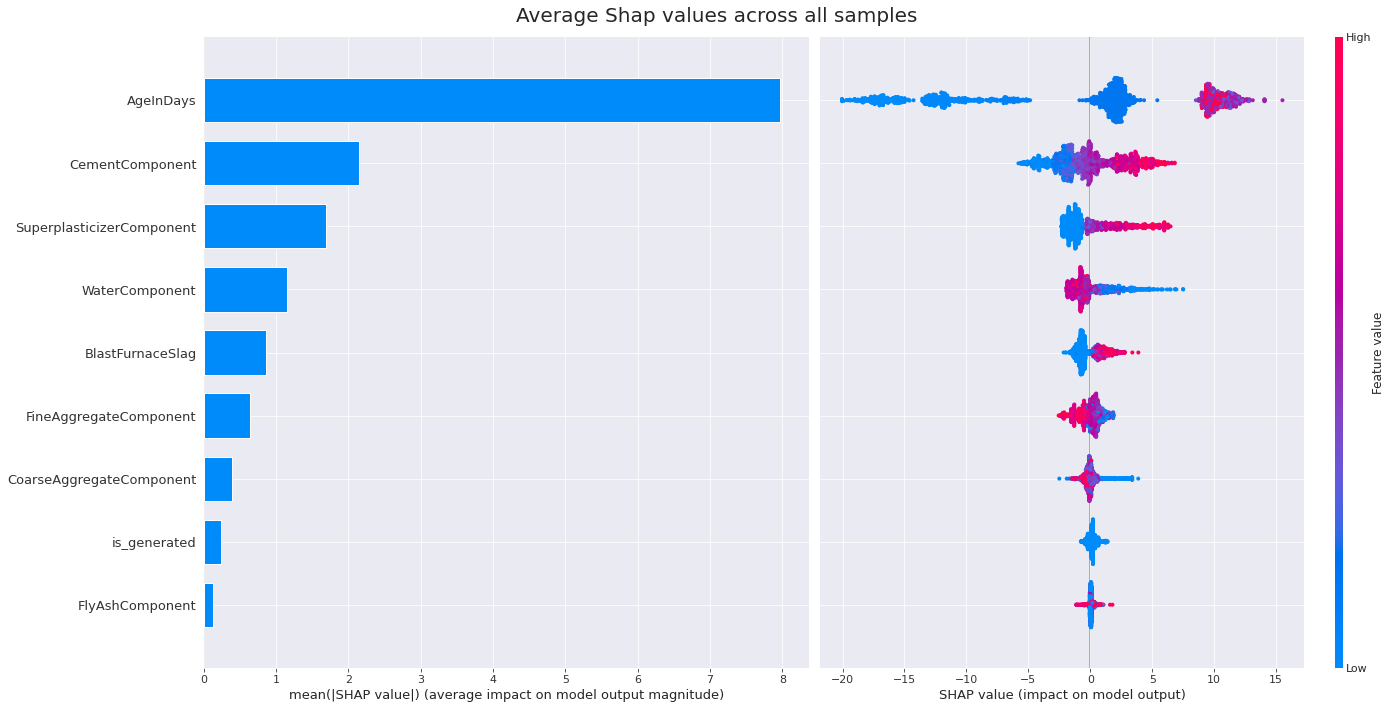

In [55]:
fig = plt.figure()
ax0 = fig.add_subplot(1,2,1)
shap.summary_plot(shap_values, X_test,max_display = 400, plot_size = [20,10], show= False, plot_type ="bar")
ax1 = fig.add_subplot(1,2,2)
shap.summary_plot(shap_values, X_test,max_display = 400, plot_size = [20,10], show= False)
ax1.set_yticklabels([])
fig.suptitle("Average Shap values across all samples", fontsize = 20)
plt.tight_layout()
plt.show()

<blockquote style="margin-right:auto; margin-left:auto; background-color: #9debb2; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Notes: Shapey Summary plot: </span></b>

* We are looking out for total importance and clumps of color  (i.e clumps of red or blue) 
    *  AgeInDays is massively importance and also has large clumps of blue (i.e low target value) 
        * We should look at creating new features from AgeInDays i.e. clipping, bucket values, thresholds etc or mathematical operations 

### Force Plot
The forceplot above looks at a number of samples and shows how certain (important) features influenced the final model prediction i.e. How these features push the model to predict the target

In [56]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0:1,:])

<div class='alert alert-block alert-success'><b><span style="color:blue;font-size:1.2em;"> </span></b>
Below is a force_plot of ALL the samples, use the dropdowns on the x and y axis to filter by specific features

In [57]:
#shap.force_plot(explainer.expected_value, shap_values, X_test)

<span style="color:orange;font-size:1.8em;">Feature Interaction / Feature Dependency </span>
    
Below we look at the interaction and relationship **between features** 

#### Interaction Values
Shap Interaction values are the fantastic as visualizing how features affect others in relation to the models prediction 

In [58]:
# Get interaction values
shap_interaction_values = explainer.shap_interaction_values(X_test)

### 1. Heatmap plot of shap interaction values 

Taken from [analysing interactions with shap](https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a):
1. To start we will calculate the absolute mean for each cell across all matrices. 
2. We take the absolute values as we do not want positive and negative SHAP values to offset each other. 
3. Because the interaction effects are halved, we also multiply the off diagonals by 2. 
4. We then display this as a heatmap.


#### 1a Absolute mean shap interactions 
* We get the **absolute mean** of the shap interactions 
 * the absolute of the values gives us the magnitude of the interaction and includes both negative and postive probability (i.e. adds them together as positives) 
 * if we want the overall result , we must remove the absolute calculation and only calculate the mean shap interactions 

In [59]:
# Get absolute mean of matrices
abs_mean_shap = np.abs(shap_interaction_values).mean(axis =0)

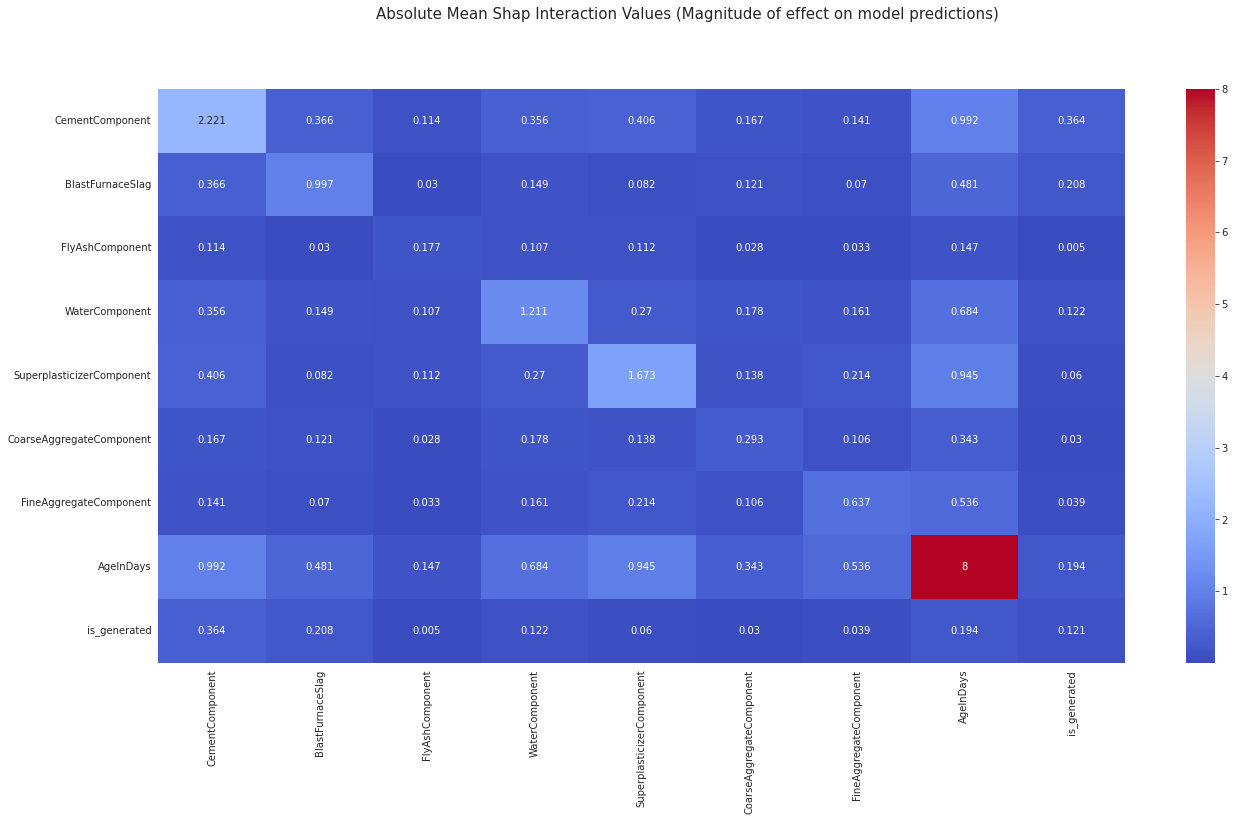

In [60]:
fig,ax = plt.subplots(figsize = (20, 12)) 

df = pd.DataFrame(abs_mean_shap, index=X_test.columns, columns=X_test.columns)
df.where(df.values == np.diagonal(df),df.values*2, inplace=True)
sns.heatmap(df.round(decimals=3), cmap='coolwarm', annot=True, fmt='.6g', cbar=True )

ax.tick_params(axis='x', labelsize=10, rotation=90)
ax.tick_params(axis='y',  labelsize=10)
plt.suptitle("Absolute Mean Shap Interaction Values (Magnitude of effect on model predictions)",fontsize=15)
plt.tight_layout(pad = 4)
plt.show()

Lets remove the upper triangle so as not to see the interaction of features with themselves

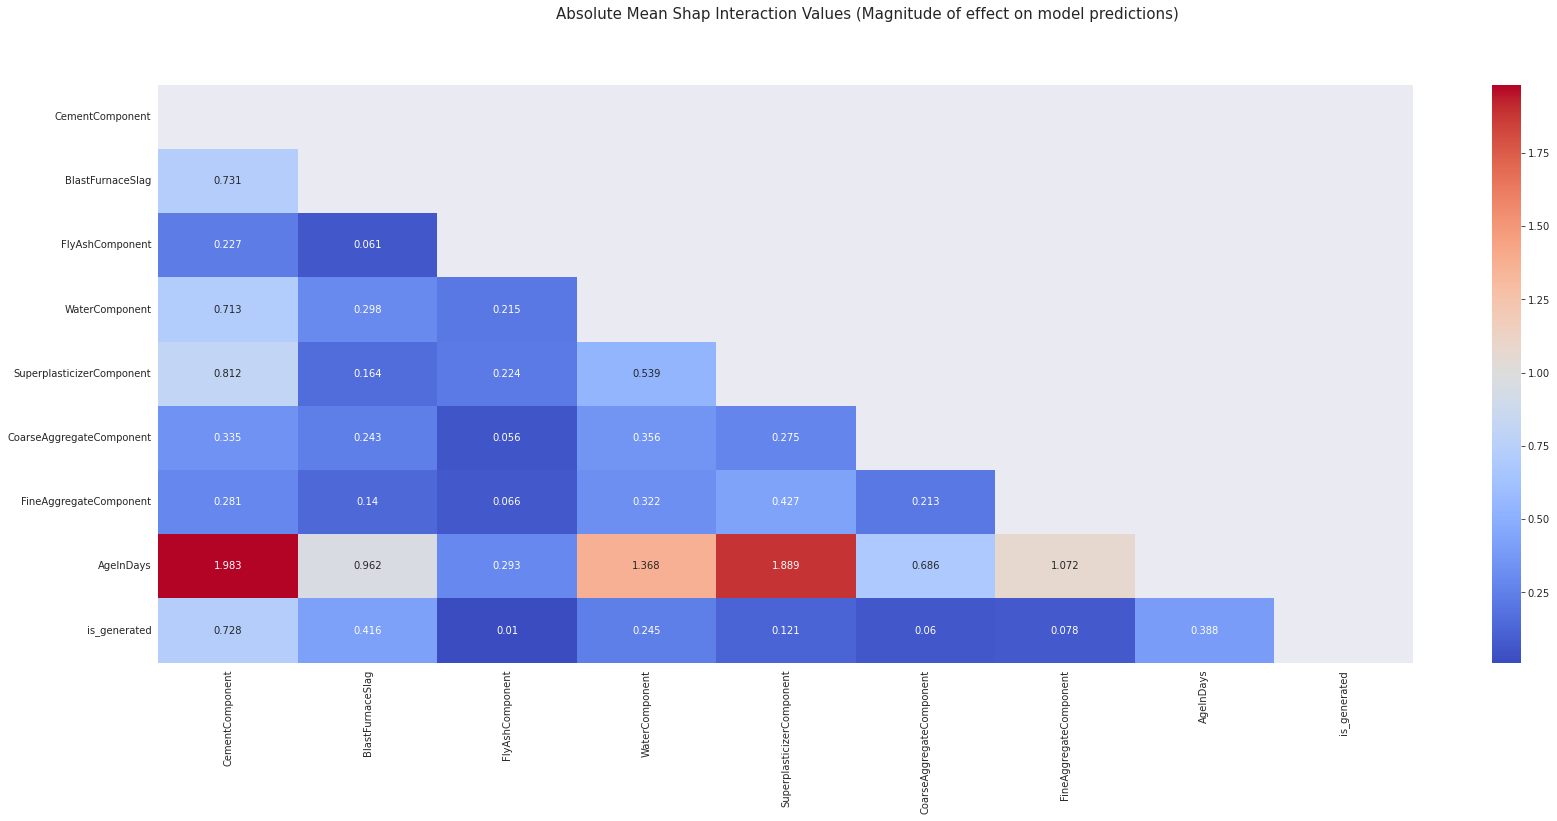

In [61]:
fig,ax = plt.subplots(figsize = (25, 12)) 

df = pd.DataFrame(abs_mean_shap, index=X_test.columns, columns=X_test.columns)
df.where(df.values == np.diagonal(df),df.values*2, inplace=True)
upper_triangle = np.triu(np.ones_like(df, dtype=bool))
sns.heatmap(df.round(decimals=3), cmap='coolwarm', annot=True, fmt='.6g', cbar=True , mask= upper_triangle )

ax.tick_params(axis='x', labelsize=10, rotation=90)
ax.tick_params(axis='y',  labelsize=10)
plt.suptitle("Absolute Mean Shap Interaction Values (Magnitude of effect on model predictions)",fontsize=15)
plt.tight_layout(pad = 4)
plt.show()

<blockquote style="margin-right:auto; margin-left:auto; background-color: #9debb2; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Notes: </span></b>
    
* Again **AgeInDays** is an important feature
    * We know it is highly correlated with SuperPlasticComponent so lets ignore this. 
* We see high shap values in **AgeInDays** and **CementComponent**. 
        * We need to create some features with this interaction i.e. mathematical operations between the 2 (add, subtract, group etc)

#### 1b Mean shap interactions 
* Gives us the feature interaction value that and the overall push that these features have on the models prediction i.e. red = high probability of class 

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Notes: </span></b>
As this is a Regression problem, this wont make much sense as we wont know the value of the feature vs the impact to Target (it makes more sense with Classification problems)

In [62]:
# Get absolute mean of matrices
# mean_shap = np.array(shap_interaction_values).mean(axis =0)

In [63]:
# fig,ax = plt.subplots(figsize = (25, 12)) 

# df = pd.DataFrame(mean_shap, index=X_test.columns, columns=X_test.columns)
# df.where(df.values == np.diagonal(df),df.values*2, inplace=True)
# sns.heatmap(df.round(decimals=3), cmap='coolwarm', annot=True, fmt='.6g', cbar=True  )

# ax.tick_params(axis='x', labelsize=10, rotation=90)
# ax.tick_params(axis='y',  labelsize=10)
# plt.suptitle("Mean Shap Interaction Values (Overall effect on model predictions)",fontsize=15)
# plt.tight_layout(pad = 4)
# plt.show()

#### Dependence plots
* Dependence plots require a lot of investigation and testing. We look at the relationship of 2 features and how they influence the **shap values** and **shap interactions**  (i.e. the model output) 
* Below I took a feature with a high average Shap value (see summary plot i.e. alcohol) and look at its relationship with features that interact highly with it (see heatmaps above). This will hopefully allow us to find any additional feature we can create (i.e clip values, multiply/Add/Subtract features , polynomial features etc) 

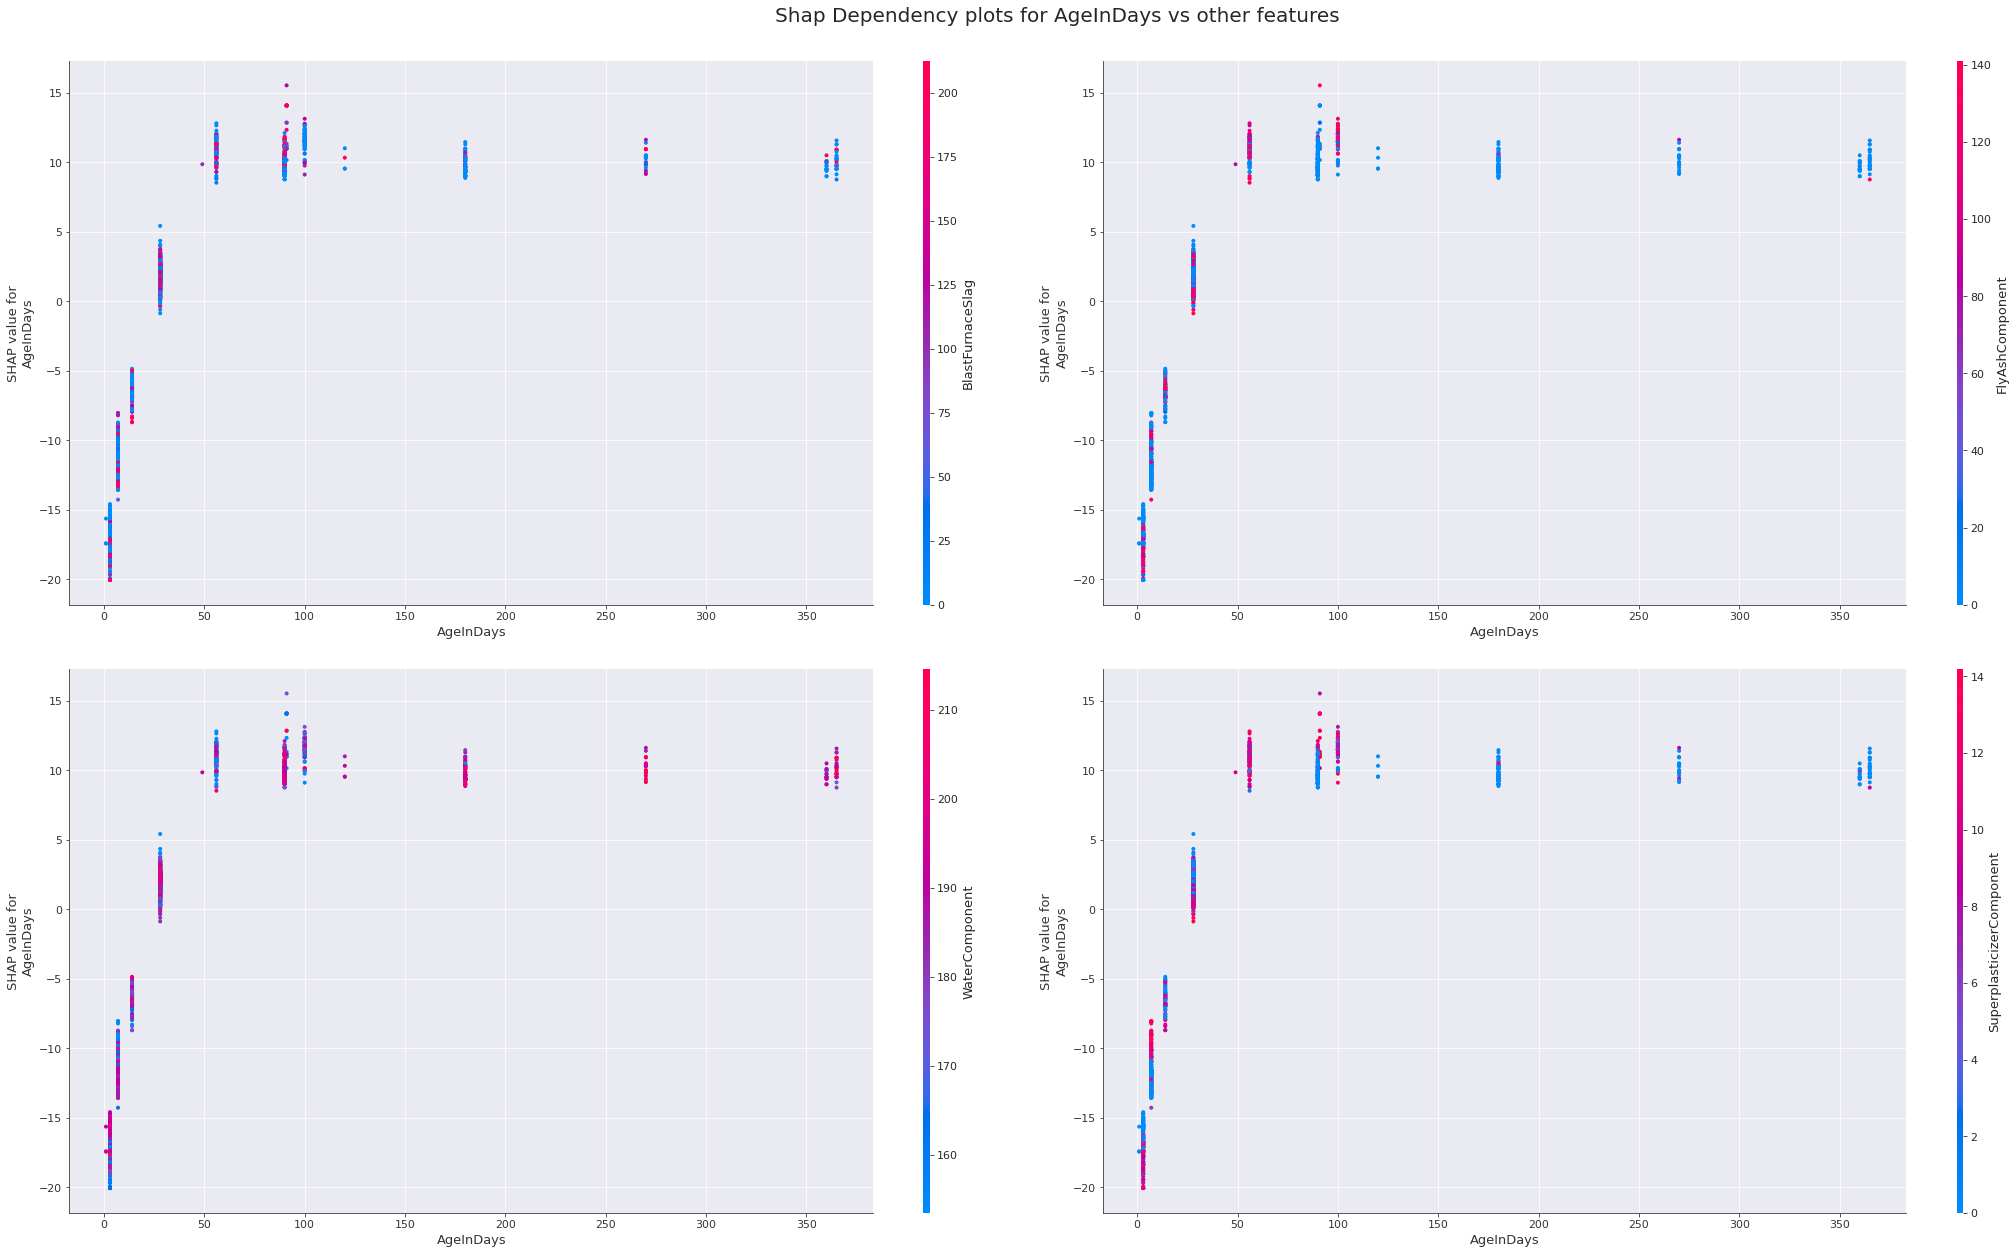

In [64]:
fig = plt.figure()
for i in range(1,5):
    axes = fig.add_subplot(2,2,i)
    shap.dependence_plot("AgeInDays", shap_values, X_test, display_features=X_test, interaction_index=i, show=False,ax= axes)
plt.gcf().set_size_inches(30,18)
fig.suptitle("Shap Dependency plots for AgeInDays vs other features", fontsize = 20)
plt.tight_layout(pad =3)
plt.show()

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Notes: </span></b>

 * There is some color clumping but nothing noteworthy

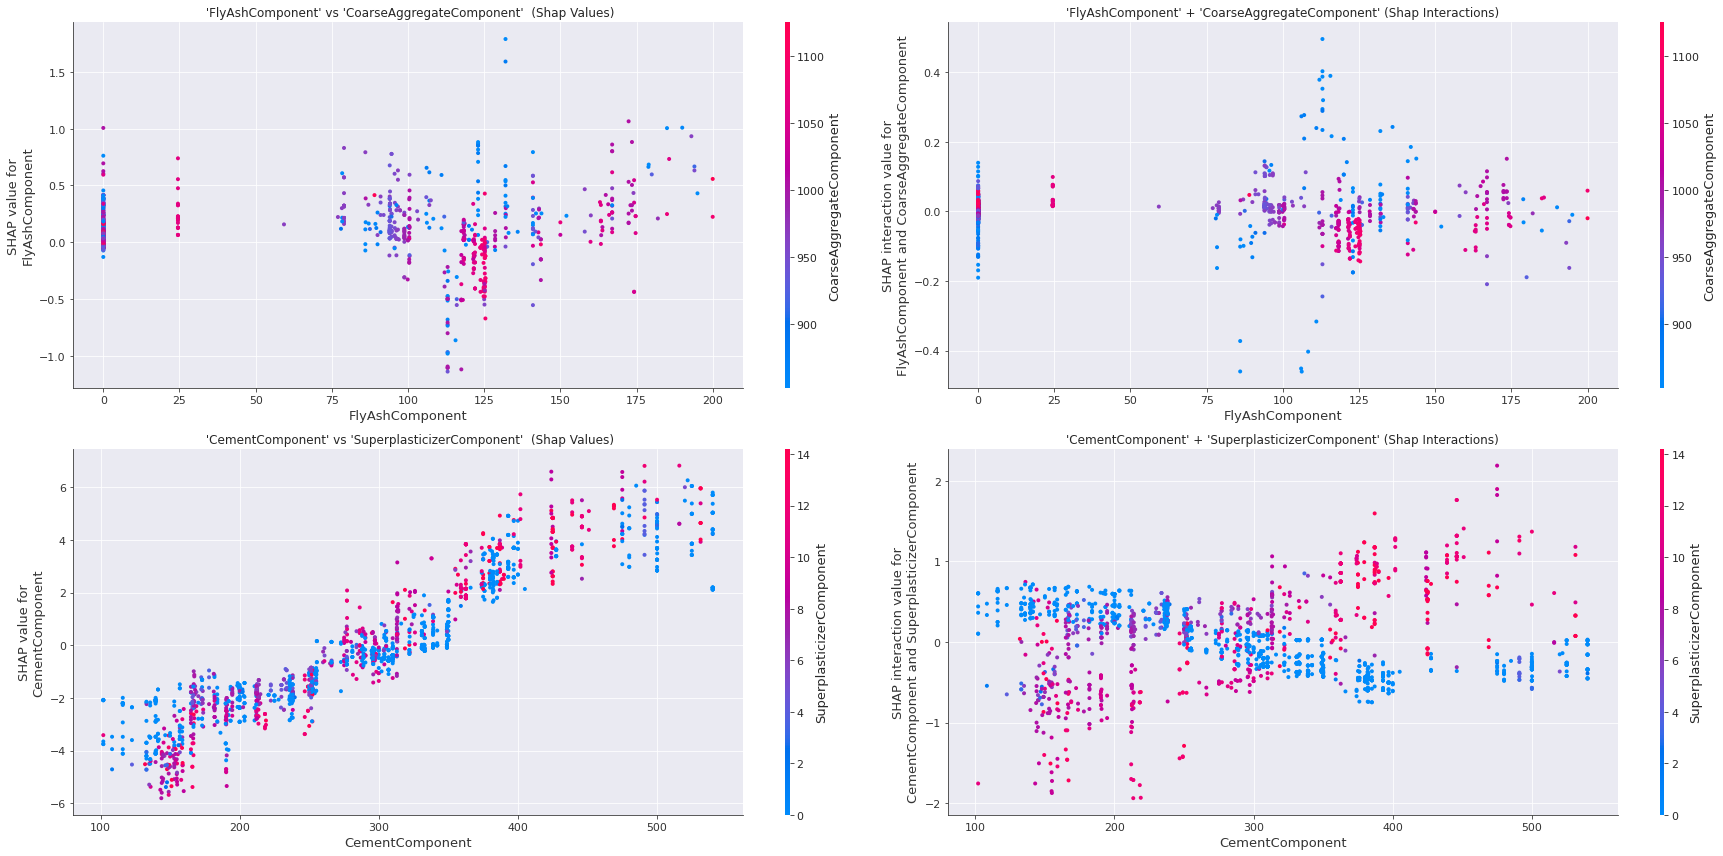

In [65]:
fig = plt.figure()
ax0 = fig.add_subplot(2,2,1)
shap.dependence_plot("FlyAshComponent", shap_values, X_test, display_features=X_test, interaction_index="CoarseAggregateComponent" ,show=False,ax= ax0)
ax0.set_title(" 'FlyAshComponent' vs 'CoarseAggregateComponent'  (Shap Values)" )
ax1 = fig.add_subplot(2,2,2)
shap.dependence_plot( ( "FlyAshComponent","CoarseAggregateComponent"),  shap_interaction_values, X_test, display_features=X_test, show=False, ax= ax1)
ax1.set_title("'FlyAshComponent' + 'CoarseAggregateComponent' (Shap Interactions)" )

if PCA_run:
    ax2 = fig.add_subplot(2,2,3)
    shap.dependence_plot("AgeInDays", shap_values, X_test, display_features=X_test, interaction_index="pca_1" ,show=False,ax= ax2)
    ax2.set_title(" 'AgeInDays' vs 'pca_1'  (Shap Values)" )
    ax3 = fig.add_subplot(2,2,4)
    shap.dependence_plot( ( "AgeInDays","pca_1"),  shap_interaction_values, X_test, display_features=X_test, show=False, ax= ax3)
    ax3.set_title("'AgeInDays' + 'pca_1' (Shap Interactions)" )
else: 
    ax2 = fig.add_subplot(2,2,3)
    shap.dependence_plot("CementComponent", shap_values, X_test, display_features=X_test, interaction_index="SuperplasticizerComponent" ,show=False,ax= ax2)
    ax2.set_title(" 'CementComponent' vs 'SuperplasticizerComponent'  (Shap Values)" )
    ax3 = fig.add_subplot(2,2,4)
    shap.dependence_plot( ( "CementComponent","SuperplasticizerComponent"),  shap_interaction_values, X_test, display_features=X_test, show=False, ax= ax3)
    ax3.set_title("'CementComponent' + 'SuperplasticizerComponent' (Shap Interactions)" )
    
plt.gcf().set_size_inches(25,12)
plt.tight_layout()
plt.show()

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;"> Notes: </span></b>

##### We want to isolate High/Low  Shap values and clumps of color
* We dont get much from these dependency plots 

# 🧊  Muti-Model Testing 🧊 
In this section we will test multiple models. This will allow use to understand which model would be best to optimize as well as allow use to ensemble models once optimized (note that we dont optimize the models in this notebook) 
The models we test should be quite broad however we can lump these into 3 categories:
* Linear i.e. Logistic regression for general linear modelling, Ridge when we dnt have optimal features selected (Ridge regularizes features) and Support Vector Machines for additional kernalization
* Trees i.e. gradient boosting such as LightGBM and XGBoost with ensemble trees convered by Random Forests and Extra Trees  
* Neural networks (see below)

**On Neural network exclusion**:\
As this is a tabular problem (not an image or text based) I will assume that neural networks wont do as well for this problem. This is also quickly apparent when looking at the data which is not homogenous in nature (i.e similar distributions, scale and source) this is usually an indicator that Neural networks wont do well with this problem\
Also due to their long run time and complexity I will note include here


<span style="color:orange;font-size:1.5em;">Solution Implementation: Skewness,  Outliers , Scaling & Imbalanced data </span>
* **Quantile Scaling** for non-stributed features should normalise our data  
* **Robust Scaling** for outlier identification
* **Standard Scaler** for linear models to assist convergence, which we will apply to all the other columns that arent outliers or skew 
* **SMOTE** to oversample our data as our classes are imbalanced 

##### Note: At the beggining of this notebook we set the paramaters to turn the above on or off. This is for testing purposes i.e. run this notebook with different paramaters to test model improvement

In [66]:
xgb_params = { 
    'objective' : "reg:squarederror",
    'n_estimators' : EPOCHS, 
    'early_stopping_rounds' :30,
    'eval_metric' : "rmse"
             }
cat_params = {'iterations':EPOCHS,
              'eval_metric' : "RMSE", 
              'learning_rate': 0.01,
              'loss_function':'RMSE'
             }
ET_params = {'max_depth':6, 'num_iterations':EPOCHS}
RF_params = { 'max_depth':8,'n_estimators':EPOCHS,
            }

GR_params = {
    'n_estimators':EPOCHS,
    'learning_rate': 0.01,
    'min_samples_split': 3,
    'max_features': "sqrt",
    'n_iter_no_change':5,
    'tol':0.01,
    'random_state':0
}

In [67]:
from sklearn.ensemble import GradientBoostingRegressor

In [68]:
# Comment out the models below to include in the Crossvalidation 

models = {
      "LinearRegression": LinearRegression(),
    "SVR":SVR( kernel = "rbf",max_iter = EPOCHS+2000),
     "lightgbm": lgb.LGBMRegressor(**lgb_params), 
    "xgboost": xgb.XGBRegressor(**xgb_params), 
    "catboost": cat.CatBoostRegressor(**cat_params),
     "ExtraTree": ExtraTreesRegressor(),
     "RandomForest":RandomForestRegressor(**RF_params),
    "GradientRegressor": GradientBoostingRegressor(**GR_params)
}

## Cross Validation

In [69]:
kfold= RepeatedKFold(n_splits=NUM_FOLDS,n_repeats=NUM_SPLITS)

In [70]:
non_dist_cols = [col for col in non_dist_cols if col in df_trn.columns]
print("skew columns:\n", non_dist_cols)
outliers = [col for col in outliers if col not in list(non_dist_cols) + pca_cols and col in df_trn.columns]
print("outliers:\n", outliers)
scaled_cols = [col for col in df_trn.drop(target,axis =1).columns if col not in outliers + list(non_dist_cols) +pca_cols]
print("scaled_cols:\n", scaled_cols) 

if len(scaled_cols)==0:
    SCALING = False

skew columns:
 ['AgeInDays']
outliers:
 ['WaterComponent']
scaled_cols:
 ['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'is_generated']


In [71]:
def cross_val(X,y):

    score_train = []
    score_val= []
    score2_val = []
    OOF_preds = []
    list_shap_values= []
    OOF_trn_preds = []   
    best_models_all =[]

    if TEST_ON_GENERATED_ONLY:
        index_ = X[X["is_generated"]==1].index
        OOF_val_preds=  pd.DataFrame(0, index = y[index_].index , columns =[col for col in range(NUM_SPLITS*NUM_FOLDS)])
    else:
        OOF_val_preds= pd.DataFrame(0, index = y.index , columns =[col for col in range(NUM_SPLITS*NUM_FOLDS)])
        
        
#     if TEST_ON_GENERATED_ONLY:
#         index_ = X[X["is_generated"]==1].index
#         OOF_val_preds=  pd.DataFrame(0, index = y[index_].index , columns =[target])
#     else:
#         OOF_val_preds= pd.DataFrame(0, index = y.index , columns = [target])

    for fold, (train_idx,val_idx) in enumerate(kfold.split(X,y)):
        X_train,y_train = X.iloc[train_idx,:], y.iloc[train_idx]
        X_test,y_test = X.iloc[val_idx,:], y.iloc[val_idx]
        print("\n###### FOLD",fold,"######")

        if TEST_ON_GENERATED_ONLY:
            index_val = X_test[X_test["is_generated"]==1].index
            y_test = y_test[index_val]
            X_test = X_test.loc[index_val, :]
            val_idx = index_val

        # run for each model and get best model (through score comparison of each model)
        best_score_val = 1e10
        best_score_trn= 1e10
        best_preds_val = None
        best_preds_trn= None
        best_preds_test = None
        best_model = None
        best_X_s = None
        best_test_s = None
        best_name = None

        for name, model in models.items():

            #Scaling
            if name in ["LinearRegression",'Ridge', "SVR"]:
                scaler = StandardScaler()
                X_train_s = scaler.fit_transform(X_train)
                X_test_s  = scaler.transform(X_test)
                X_temp = X.copy(deep = True)
                X_temp = scaler.transform(X_temp)
                test_temp = scaler.transform(df_tst)
                y_train_s = y_train.copy(deep = True)
            else:
                y_train_s = y_train.copy(deep = True)
                X_train_s, X_test_s , test_temp, X_temp = Scaling(X_train, X_test , df_tst, X )

            #Fit
            test_preds_fold, trn_preds_fold, val_preds_fold, score_train_fold, score_val_fold = base_model(X_train_s,y_train_s,X_test_s,y_test, name,model, X_temp, test_temp, False)

            print(f"{name} with score of: {score_val_fold:.2f} and score2: {r2_score(y_test, val_preds_fold):.2f}" )
            if score_val_fold < best_score_val:                
                best_score_val = score_val_fold
                best_score_trn= score_train_fold
                best_preds_val = val_preds_fold
                best_preds_trn= trn_preds_fold
                best_preds_test = test_preds_fold
                best_model = model
                best_X_s = X_temp
                best_test_s = test_temp
                best_name= name


        # use best model for predictions    
        print(f"\nbest model: {best_name}, with score {best_score_val:.2f} and score2 {r2_score(y_test, best_preds_val):.2f}" )
        best_models_all.append(best_name)
        
        OOF_val_preds.loc[val_idx, fold]   = OOF_val_preds.loc[val_idx, fold] + best_preds_val/NUM_SPLITS
        #OOF_val_preds.loc[val_idx, target] = OOF_val_preds.loc[val_idx, target] + best_preds_val/NUM_SPLITS

        score_val.append(best_score_val)
        score2_val.append(r2_score(y_test, best_preds_val))
        score_train.append(best_score_trn)
        OOF_trn_preds.append(best_preds_trn )
        OOF_preds.append(best_preds_test)

        #Shap values of best model
        if SHAP_VALS:
            explainer = shap.Explainer(best_model)
            shap_values_cv = explainer.shap_values(best_test_s)
            list_shap_values.append(shap_values_cv)

        print("Trn score:",best_score_trn)
        print("Val score:",best_score_val)
        print("Val Score2:",r2_score(y_test, best_preds_val))


    if TEST_ON_GENERATED_ONLY:
        print("\nMEAN Trn score:",np.mean(score_train))
        print("MEAN Val score:",mean_squared_error(y[index_], OOF_val_preds.sum(axis =1))**0.5)
        print("MEAN Val Score2:",r2_score(y[index_], OOF_val_preds.sum(axis =1)))
    
    else:
        print("\nMEAN Trn score:",np.mean(score_train))
        print("MEAN Val score:",mean_squared_error(y, OOF_val_preds.sum(axis =1))**0.5)
        print("MEAN Val Score2:",r2_score(y, OOF_val_preds.sum(axis =1)))
    
    if SHAP_VALS:
        return OOF_preds, OOF_trn_preds, OOF_val_preds, score_train, score_val, best_models_all, list_shap_values
    else:
        return OOF_preds, OOF_trn_preds, OOF_val_preds, score_train, score_val, best_models_all

In [72]:
if SHAP_VALS:
    test_preds, train_preds, val_preds, OOF_trn_score, OOF_val_score, best_models, shap_values = cross_val(X,y)
else:
    test_preds, train_preds, val_preds, OOF_trn_score, OOF_val_score, best_models = cross_val(X,y)


###### FOLD 0 ######
LinearRegression with score of: 14.66 and score2: 0.18
SVR with score of: 13.18 and score2: 0.34
lightgbm with score of: 12.05 and score2: 0.44
xgboost with score of: 12.15 and score2: 0.44
catboost with score of: 11.99 and score2: 0.45
ExtraTree with score of: 13.14 and score2: 0.34
RandomForest with score of: 12.11 and score2: 0.44
GradientRegressor with score of: 12.01 and score2: 0.45

best model: catboost, with score 11.99 and score2 0.45
Trn score: 11.307050261517734
Val score: 11.993507605224394
Val Score2: 0.449394893177267

###### FOLD 1 ######
LinearRegression with score of: 14.45 and score2: 0.23
SVR with score of: 13.18 and score2: 0.36
lightgbm with score of: 12.03 and score2: 0.47
xgboost with score of: 12.19 and score2: 0.45
catboost with score of: 12.00 and score2: 0.47
ExtraTree with score of: 13.41 and score2: 0.34
RandomForest with score of: 12.09 and score2: 0.46
GradientRegressor with score of: 12.04 and score2: 0.47

best model: catboost, wit

In [73]:
best_models

['catboost',
 'catboost',
 'lightgbm',
 'GradientRegressor',
 'catboost',
 'catboost',
 'catboost',
 'lightgbm',
 'catboost',
 'catboost',
 'catboost',
 'catboost',
 'catboost',
 'catboost',
 'catboost']

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;"> Notes </span></b>

* Im not happy with the final result, as our final RSME is too high compared to the target value and similar to our baseline (which was shown to be poor)
* As with this [discussion](https://www.kaggle.com/competitions/playground-series-s3e9/discussion/391011) there are many **duplicates** in the dataset that have **different target values**. 
    * This is very concerning as our models wont know what value to predict as each duplicate sample has a differnt value 
    * We can only hope that ensembling sorts this out as my finding the value between  all these predictions 
    
* My Assumption is that **ensembling** or **calibration** will be a good candidate as it should find a middle ground between the predictions  
    
        * Interesting that Catboost is the prominant best model. Maybe we need to set columns as categorical as this is catboosts speciality?

## Setup submissions 

In [74]:
sub[target]  = 0
sub_base =  sub.copy(deep= True)
sub_ensemble = sub.copy(deep= True)
sub_best_cv = sub.copy(deep= True)
sub_cal = sub.copy(deep = True)
mean_ensemble = sub.copy(deep = True)

In [75]:
# Base model submission
sub_base[target]=test_preds_base
print("Base Model (lightgbm) values (inital 5 rows):")
sub_base.to_csv("submission_base.csv")
sub_base.head()

Base Model (lightgbm) values (inital 5 rows):


,Strength
id,
5407,48.229894
5408,19.495521
5409,33.604786
5410,48.258017
5411,32.844419


In [76]:
# Best CV model submission 
sub_best_cv_trn = y.copy(deep = True)
sub_best_cv_trn = train_preds[np.argmin(OOF_val_score)]

sub_best_cv[target] = test_preds[np.argmin(OOF_val_score)]
print(f"Best CV model score: {min(OOF_val_score):.2f}]")
print("Inital 5 rows")
sub_best_cv.to_csv(f"sub_best_cv_{min(OOF_val_score):.2f}.csv")
sub_best_cv.head()

Best CV model score: 11.75]
Inital 5 rows


,Strength
id,
5407,47.827025
5408,19.999536
5409,34.288159
5410,46.720534
5411,29.892030


# 🥣 Ensembling 🥣
There are a number of ensembling techniques and I will state below my most used:
1. <span style="color:orange;font-size:1em;">Mode, Hard Voting, Soft Voting Ensemble</span>
2. <span style="color:orange;font-size:1em;">Weighted Average Ensemble</span> 
3. <span style="color:orange;font-size:1em;">Hill Climbing</span> ==> iterative process: adding predictions to others and multipling by random weights to find the best (**Note:** This can be quite complicated and I do use this process in this notebook) 
4. <span style="color:orange;font-size:1em;">Optimization methods</span> ==> Similar to High Climbing however it uses specialised optimization algorithms (please see link bellow on how to implement)

More on how these are implemented please check out my [notebook here ](https://www.kaggle.com/code/slythe/post-ensembling-hill-climbing-weighted-scipy)

### Hard and Soft Voting
As we are looking at a multi-class classification problem. We can ensemble a few other ways such as 
* Mode: Get the **most frequent prediction** from all the models i.e. four models predicted the class as 3 and two models predicted the class as 1, therefore we use class 3 (most frequent) 
* Soft-Voting (also called Mean Ensembling): Sum all the **probabilities** and divide by the number of models to get the **mean probabilities**
 * This is only effective if the models are optimized (which ours arent) 
* Hard Voting: Identify the **highest probability** accross all models, this is the prediction 
    * This is usually better than Soft-voting when model are NOT optimized by less so if they models are optimized 

In [77]:
# Get a dataframe of train and test predictions 
all_trn_preds = pd.DataFrame(index = df_trn.index)
all_tst_preds = pd.DataFrame(index = df_tst.index)

for i, preds in enumerate(train_preds):
    all_trn_preds[f"{OOF_val_score[i]}"] = train_preds[i]
    all_tst_preds[f"{OOF_val_score[i]}"] = test_preds[i]
all_tst_preds

,11.993507605224394,11.998285297826392,12.158224968331275,11.946235732194154,12.183052684922353,12.064965346688737,12.296985042420863,12.315403990236819,11.830054417610995,11.883751494122393,12.275243461870591,12.220876698241566,11.753980770075819,12.197443959529833,11.945649311081207
id,,,,,,,,,,,,,,,
5407,47.788371,47.923935,45.676819,47.280468,49.463812,48.033543,47.687950,47.581071,48.683180,48.005745,47.926394,47.034041,47.827025,47.719835,48.097461
5408,19.925733,19.841324,21.034739,19.950308,19.490921,19.915469,19.657047,19.980902,19.906686,19.882843,19.805324,19.773433,19.999536,20.094924,19.735837
5409,33.794254,34.169523,34.659485,34.142937,32.893700,33.429750,33.780974,33.925516,34.206001,33.517984,33.734386,33.256025,34.288159,33.882383,33.639502
5410,45.928862,46.873988,45.877768,45.444709,47.488963,46.872545,47.062747,44.920877,47.039690,46.872058,46.263392,47.148524,46.720534,45.927117,46.563791
5411,32.394869,29.869116,29.792172,29.527853,30.577306,30.162672,32.917521,29.612928,32.711422,29.842816,31.250200,30.989525,29.892030,31.266155,33.007892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9007,34.460030,33.993122,32.937891,32.174165,33.484217,32.743306,34.466199,30.030732,35.219195,34.522521,34.150815,33.745741,34.422766,34.175650,33.976671
9008,35.194762,35.541811,37.669474,35.482193,35.327878,35.633692,35.513728,37.261916,35.516851,35.457117,35.634187,35.178616,35.814748,35.637512,35.571272
9009,39.419317,39.914074,41.399323,38.654582,39.855160,39.328230,40.003406,43.167424,39.574417,39.434608,38.952345,39.956738,39.663240,39.335502,39.964967


#### Soft Voting (Mean) Ensembling

In [78]:
# Get mean ensemble
mean_tst_preds = all_tst_preds.mean(axis =1)
mean_trn_preds =  all_trn_preds.mean(axis =1)

mean_ensemble[target]= mean_tst_preds.values

mean_score = mean_squared_error(y, mean_trn_preds)**0.5
print("MEAN Ensemble Score:",mean_score)
mean_ensemble.to_csv(f"mean_ensemble_{mean_score:.2f}.csv")
mean_ensemble

MEAN Ensemble Score: 11.042308286858171


,Strength
id,
5407,47.781977
5408,19.933002
5409,33.821372
5410,46.467038
5411,30.920965
...,...
9007,33.633535
9008,35.762384
9009,39.908222


## Weighted Ensembling
* Multiple the predictions by their relative score (wieght) and divide by the sum of the scores 
* In this notebook I will focus on **weighted ensembling** as this usually gets decent results for very little coding

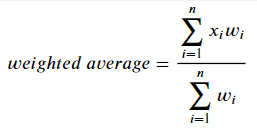

In [79]:
sub_ensemble_trn = y.copy(deep = True)

for i, preds in enumerate(test_preds):
    sub_ensemble[target] = sub_ensemble[target] + (test_preds[i] * OOF_val_score[i]) #multiply preds by their corresponding auc score
    sub_ensemble_trn= sub_ensemble_trn + (train_preds[i] * OOF_val_score[i])
    
sub_ensemble_trn =   (sub_ensemble_trn/ sum(OOF_val_score) ).values

weighted_score = mean_squared_error(y, sub_ensemble_trn)**0.5
print("MEAN Ensemble Score:",weighted_score)

sub_ensemble[target] =   (sub_ensemble[target]/ sum(OOF_val_score)).values 
sub_ensemble.to_csv(f"sub_weighted_ensemble_{weighted_score:.2f}.csv")
sub_ensemble.head()

MEAN Ensemble Score: 10.976255583222098


,Strength
id,
5407,47.779665
5408,19.932952
5409,33.819542
5410,46.465066
5411,30.921470


# ✅ Post-Prediction Analysis & Manipulation ✅

#### i. Calibration: 
* Our models may not be optimized and a simple linear model trained on our training predictions may be able to smooth out any inconsistencies with our model through fitting and additional linear model on our predictions 

### i. Calibration
* We will calibrate our **test predictions** by fitting a linear regression model to a dataframe of our **training predictions** from each models Cross Validation. 
* This fitted calibrated model will then predict the **test predictions** and hopefully smooth out the values and provide a final test prediction 

In [80]:
if CALIBRATION == "linear":
    model = LinearRegression()
elif CALIBRATION=='gaus': 
    model = GaussianNB()
    
model.fit(all_trn_preds, np.ravel(y))
y_cal_trn  = model.predict(all_trn_preds)
y_cal_test  = model.predict(all_tst_preds)
y_cal_test = y_cal_test
y_cal_test

array([49.88347561, 20.75459154, 32.48122325, ..., 45.41393307,
       29.84258628, 20.36200113])

In [81]:
cal_score = mean_squared_error(y,y_cal_trn )**0.5
print("Calibrated Score",cal_score)

Calibrated Score 10.224562067582717


In [82]:
sub_cal[target] = y_cal_test
print("Calibrated values (inital 5 rows)")
sub_cal.to_csv(f"sub_cal_{cal_score:.2f}.csv")
sub_cal.head()

Calibrated values (inital 5 rows)


,Strength
id,
5407,49.883476
5408,20.754592
5409,32.481223
5410,47.530001
5411,28.691632


## Post-Prediction Analysis 

In [83]:
import gc
gc.collect()

270

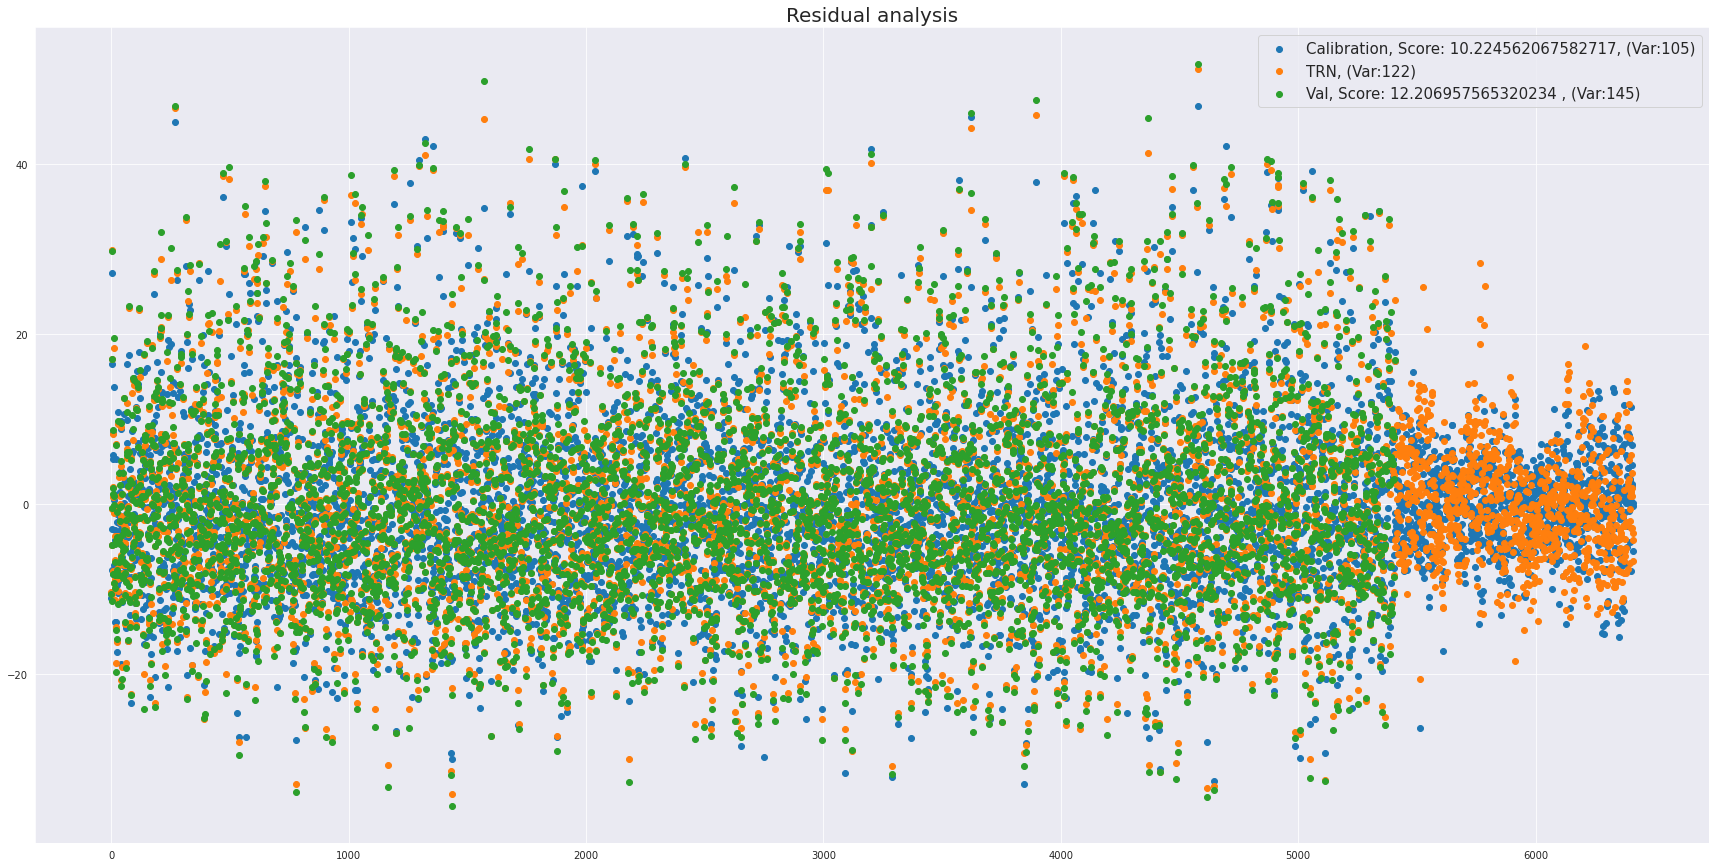

In [84]:
fig, ax = plt.subplots(1,1, figsize = (30,15),sharey = True)
ax = np.ravel(ax)

res_cal = y.values -y_cal_trn
ax[0].scatter(x = [i for i in range(len(res_cal))], y = res_cal, label = f"Calibration, Score: {cal_score}, (Var:{np.var(res_cal):.0f})")
del res_cal
gc.collect()

res_trn = y.values- all_trn_preds.mean(axis =1).values
ax[0].scatter(x = [i for i in range(len(res_trn))], y = res_trn ,label = f"TRN, (Var:{np.var(res_trn):.0f})")
del res_trn

if TEST_ON_GENERATED_ONLY:
    res_val = y[X[X["is_generated"]==1].index].values - val_preds.sum(axis =1).values
else:
    res_val = y.values - val_preds.sum(axis =1).values
ax[0].scatter(x = [i for i in range(len(res_val))], y = res_val, label = f"Val, Score: {score_val} , (Var:{np.var(res_val):.0f})")
ax[0].set_title("Residual analysis", fontsize = 20)

ax[0].legend(fontsize= 15)
plt.show()

<blockquote style="margin-right:auto; margin-left:auto; background-color: #9debb2; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Additional Things to Try : </span></b>

* PCA columns 
* Feature engineering 
    * AgeInDays?